In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np

import ipywidgets as widgets
from matplotlib import pyplot as plt

import anndata2ri

# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

root_dir = '/n/scratch3/users/c/cl266/'
data_dir = '../GEO/GSE167422/'

# This is the Waddington-OT package.
import math
import wot

# Do this last, because it interacts with anndata2ri and can lead to failure.
%load_ext rpy2.ipython

Error: .onLoad failed in loadNamespace() for 'pbdZMQ', details:
  call: fun(libname, pkgname)
  error: Could not load  /home/cl266/R_4.2.1/pbdZMQ/libs/libzmq.so : Error in dyn.load(dn.file, local = FALSE) : 
  unable to load shared object '/home/cl266/R_4.2.1/pbdZMQ/libs/libzmq.so':
  /home/cl266/R_4.2.1/pbdZMQ/libs/libzmq.so: undefined symbol: R_useDynamicSymbols
/tmp/ipykernel_18947/1200805799.py:12: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/tmp/ipykernel_18947/1200805799.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


-----
anndata     0.11.0.dev24+gaf7a5b7
scanpy      1.9.6
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.2.0
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.4
importlib_resources         NA
ipykernel                   6.26.0
ipython_genutils            

In [2]:
sc.logging.print_versions()

-----
anndata     0.11.0.dev24+gaf7a5b7
scanpy      1.9.6
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.2.0
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.4
importlib_resources         NA
ipykernel                   6.26.0
ipython_genutils            

In [3]:
%%R -i data_dir
suppressPackageStartupMessages(library(Seurat))
library(tidyverse)

"%ni%" <- Negate("%in%")

data.dir <- data_dir

sessionInfo()


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.3.19-gcc-9.2.0/lib/libopenblas_haswellp-r0.3.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 

# Process for scanpy and WOT analysis

## Convert 3F Seurat object to scanpy Anndata object

In [19]:
%%R -i data_dir

tictoc::tic()
integrated <- readRDS( paste0( data.dir, "20230509_3F_integrated.rds") )
tictoc::toc()

integrated@meta.data %>%
dplyr::count( free.annotation2, library, condition3 )

125.944 sec elapsed
          free.annotation2               library condition3    n
1                    D02F0          mm10_hrepr_1         0F 2722
2                    D02F3                  3F-1         3F 3536
3                    D02F3                  3F-2         3F 3943
4                    D03F0                    D3         0F  691
5                    D03F3                    D3         3F 3012
6                    D04F0                    D4         0F  119
7                    D04F0          mm10_hrepr_3         0F 2802
8                    D04F0            rererepr_3         0F   20
9                    D04F3                  3F-1         3F   38
10                   D04F3                  3F-2         3F   22
11                   D04F3               3FD04-1         3F 2487
12                   D04F3               3FD04-2         3F 2103
13                   D04F3                    D4         3F  701
14                   D04F3              rerepr_1         3F 1144
15   

## Convert to AnnData object and compare

In [33]:
%%R -o bdata

tictoc::tic()
DefaultAssay( integrated ) <- "RNA"
bdata <- as.SingleCellExperiment(integrated)
tictoc::toc()

89.896 sec elapsed


In [34]:
bdata

AnnData object with n_obs × n_vars = 80039 × 37615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'percent.mito', 'percent.ribo', 'percent.rbc', 'percent.transgenes', 'library', 'barcode', 'barcode2', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'free.annotation', 'nCount_3species', 'nFeature_3species', 'mUMIs', 'cUMIs', 'hUMIs', 'tUMIs', 'multiplet.99', 'multiplet.95', 'multiplet.90', 'mito.fraction.mm10', 'mito.fraction.hg38', 'mito.fraction.gg6a', 'query', 'batch', 'percent.ribo.expanded', 'doublet_scores', 'predicted_doublets', 'doublet.barcode', 'integrated_snn_res.0.2', 'integrated_snn_res.0.3', 'integrated_snn_res.0.4', 'free.annotation2', 'bulk', 'condition3', 'day3', 'pseudobulk', 'label.0.2', 'cluster.order.0.2', 'contour', 'ident'
    layers: 'logcounts'

normalizing counts per cell
    finished (0:00:05)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

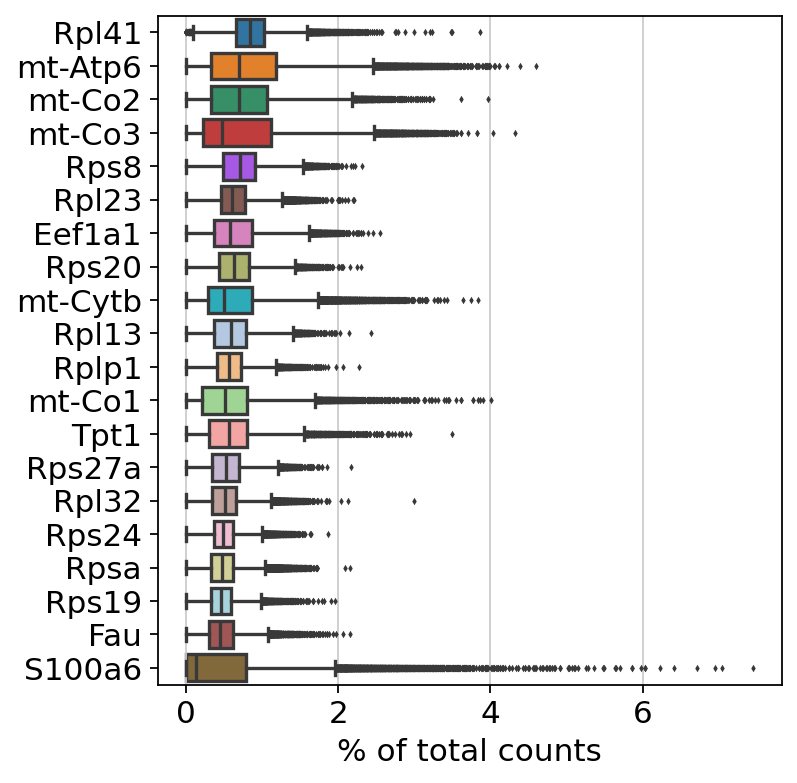

In [35]:
sc.pl.highest_expr_genes(bdata, n_top=20, )

In [36]:
# Without this normalization, all are just counts!
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)

normalizing counts per cell
    finished (0:00:01)


In [37]:
sc.pp.pca(bdata, n_comps=50)
sc.pp.neighbors(bdata, n_pcs=20, n_neighbors=20) 

computing PCA
    with n_comps=50
    finished (0:03:29)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


## import seurat shared neighborhood metric


In [38]:
%%R

# copy over the original SNN

DefaultAssay( integrated ) <- "integrated"

graph <- integrated[["integrated_snn"]]

Matrix::writeMM( as(graph,"Matrix"), file = glue::glue("{data.dir}20231001_graph_dims20.mtx") )

NULL


In [39]:
from scipy.io import mmread
graph = mmread( data_dir + '20231001_graph_dims20.mtx')

# Replace the neighborhood connectivity graph to Seurat integrated graph
from scipy.sparse import csr_matrix
bdata.obsp['connectivities'] = csr_matrix(graph)

In [40]:
# There is a problem with StringArray type of indices that needs to be corrected to objects

bdata.obs.index = bdata.obs.index.astype('object')
bdata.var.index = bdata.var.index.astype('object')

In [41]:
bdata.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,nCount_ambiguous,nFeature_ambiguous,percent.mito,...,integrated_snn_res.0.4,free.annotation2,bulk,condition3,day3,pseudobulk,label.0.2,cluster.order.0.2,contour,ident
AAACCCACAAAGGCGT_1_1,SeuratProject,21550.0,4613,21881.0,4653,2121.0,1367,178.0,151,0.079536,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
AAACCCACACAGTCCG_1_1,SeuratProject,20942.0,4965,21193.0,4994,3840.0,1792,210.0,194,0.060023,...,8,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,8
AAACGAAAGGTCCAGA_1_1,SeuratProject,15497.0,3644,15689.0,3661,2886.0,1590,150.0,129,0.101052,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
AAACGAACAGCTTTGA_1_1,SeuratProject,9042.0,2720,9139.0,2744,1164.0,791,81.0,73,0.062044,...,3,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,3
AAACGAAGTTACACTG_1_1,SeuratProject,17418.0,3675,17592.0,3708,2018.0,1169,148.0,126,0.103341,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCGTGCTCT-1_7_6,3FD08-3,14014.0,3429,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.109105,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGGTTCAACCGCCA-1_7_6,3FD08-3,16269.0,3995,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.051509,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGGTTCACAGAGAC-1_7_6,3FD08-3,27328.0,5291,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.083138,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGTTGCAGCACAAG-1_7_6,3FD08-3,26022.0,4123,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.035009,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2


In [42]:
# write this
bdata.write( data_dir + '20231001_pzlonly_init.h5ad')

## Preprocessing and combat batch correction

In [43]:
bdata = sc.read(data_dir + '20231001_pzlonly_init.h5ad')
bdata

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 80039 × 37615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'percent.mito', 'percent.ribo', 'percent.rbc', 'percent.transgenes', 'library', 'barcode', 'barcode2', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'free.annotation', 'nCount_3species', 'nFeature_3species', 'mUMIs', 'cUMIs', 'hUMIs', 'tUMIs', 'multiplet.99', 'multiplet.95', 'multiplet.90', 'mito.fraction.mm10', 'mito.fraction.hg38', 'mito.fraction.gg6a', 'query', 'batch', 'percent.ribo.expanded', 'doublet_scores', 'predicted_doublets', 'doublet.barcode', 'integrated_snn_res.0.2', 'integrated_snn_res.0.3', 'integrated_snn_res.0.4', 'free.annotation2', 'bulk', 'condition3', 'day3', 'pseudobulk', 'label.0.2', 'cluster.order.0.2', 'contour', 'ident'
    uns: 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'connectiv

normalizing counts per cell
    finished (0:00:04)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

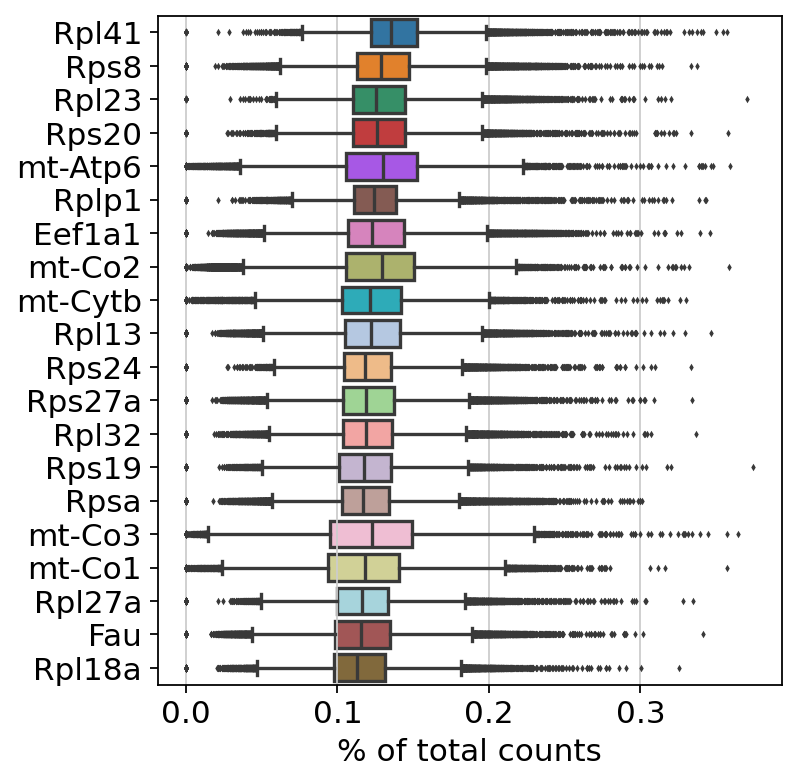

normalizing counts per cell
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:03:09)


In [44]:
sc.pl.highest_expr_genes(bdata, n_top=20, )

# Without this normalization, all are just counts!
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)
sc.pp.pca(bdata, n_comps=50)

extracting highly variable genes


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


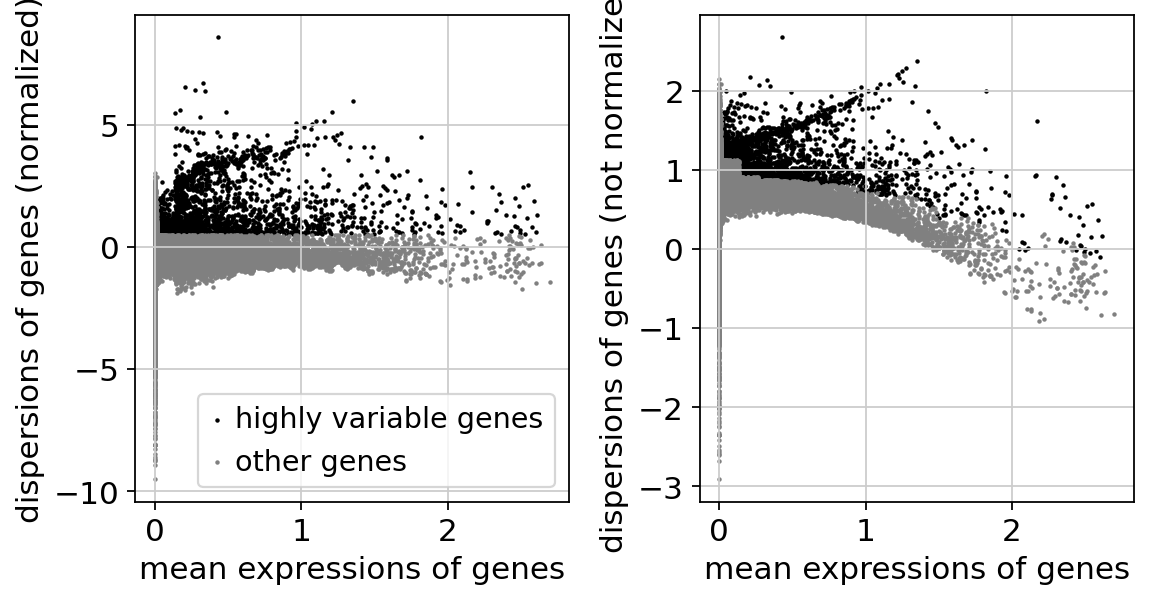

Highly variable genes: 2558


In [45]:
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bdata)

var_genes_all = bdata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

extracting highly variable genes


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to 

    finished (0:00:29)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:499: FutureWarning: The provided callable <function nanmean at 0x7f6f1c176c10> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby('gene').agg(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:499: FutureWarning: The provided callable <function nansum at 0x7f6f1c176790> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby('gene').agg(


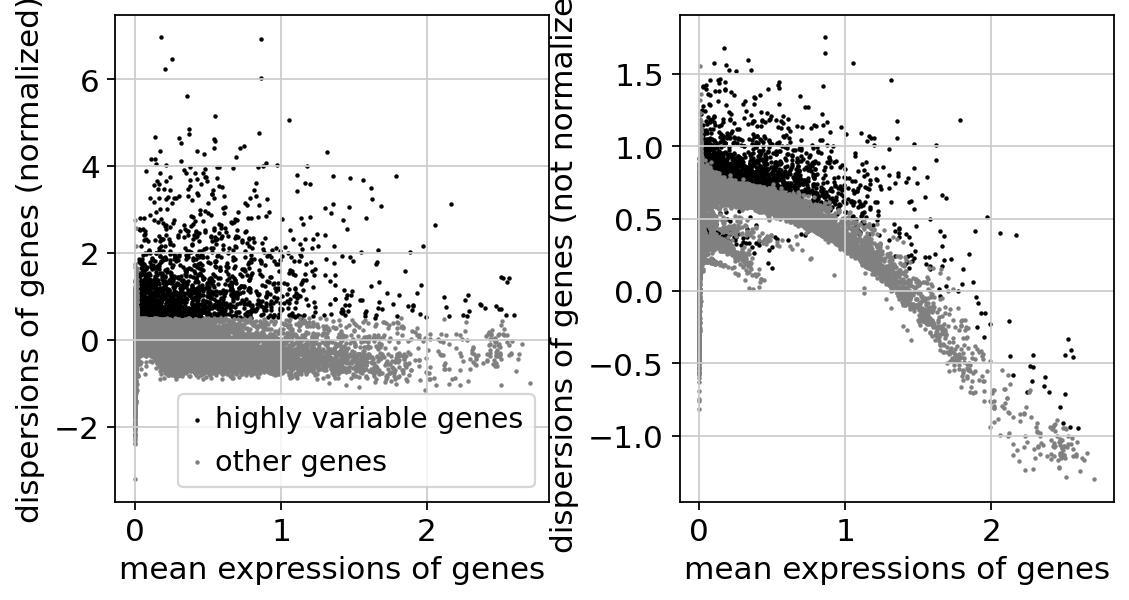

Highly variable genes intersection: 207
Number of batches where gene is variable:
highly_variable_nbatches
0    30840
1     3796
2     1182
3      658
4      485
5      447
6      207
Name: count, dtype: int64


In [46]:
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'batch')
sc.pl.highly_variable_genes(bdata )

print("Highly variable genes intersection: %d"%sum(bdata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(bdata.var.highly_variable_nbatches.value_counts())

var_genes_batch = bdata.var.highly_variable_nbatches > 0

In [47]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(bdata.var.highly_variable_nbatches == 3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & bdata.var.highly_variable_intersection))

Any batch var genes: 6775
All data var genes: 2558
Overlap: 1755
Variable genes in all batches: 658
Overlap batch instersection and all: 192


In [48]:
# var_select = bdata.var.highly_variable_nbatches > 2
var_select = bdata.var.highly_variable_nbatches > 0
var_select_stringent = bdata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
var_genes_stringent = var_select_stringent.index[var_select_stringent]
print(len(var_genes))
print(len(var_genes_stringent))

6775
1797


In [49]:
bdata_var = bdata[:,var_genes_stringent]

In [50]:
sc.pp.combat(bdata_var, key='batch') # implicitly, this is changing the .X slot.

Standardizing Data across genes.

Found 6 batches

Found 0 numerical variables:
	



/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_info = model.groupby(key).indices.values()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_items = model.groupby(batch_key).groups.items()


Fitting L/S model and finding priors

Finding parametric adjustments



/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [51]:
print(bdata_var.X[1:5,1:5]) # Now this looks more scaled isn't it??

  (0, 0)	0.6305070854145759
  (0, 1)	0.01957105915613616
  (0, 2)	0.012913375050536996
  (0, 3)	0.0061704460780840215
  (1, 0)	-0.030549599572085917
  (1, 1)	0.01957105915613616
  (1, 2)	0.012913375050536996
  (1, 3)	1.383143639955794
  (2, 0)	-0.030549599572085917
  (2, 1)	0.01957105915613616
  (2, 2)	0.012913375050536996
  (2, 3)	0.0061704460780840215
  (3, 0)	-0.030549599572085917
  (3, 1)	0.01957105915613616
  (3, 2)	0.012913375050536996
  (3, 3)	0.0061704460780840215


In [52]:
# bdata_var.write('20210118_mouse_combat.h5ad')  # this is the file for most stringent variable genes
bdata_var.write(data_dir + '20231001_mouse_pzlonly_combat_stringent.h5ad')

In [53]:
bdata_var=ad.read(data_dir + '20231001_mouse_pzlonly_combat_stringent.h5ad')

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [54]:
print(sum(bdata.var.highly_variable)) #1784
print(sum(bdata.var.highly_variable_intersection)) # 207

1784
207


# R visualization setup

In [21]:
%%R

# Consistent colour scheme for Figure 3 and Figure 4
viridis.color <- viridisLite::viridis(n=6, alpha = 0.7, begin = 0, end = 0.9, direction = 1, option = "C")

cluster.color <- c(
    "3" = viridis.color[1],
    "6" = viridis.color[2],
    "1" = viridis.color[3],
    "2" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[3],
    "5" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[4],
    "4" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[2]
)

figure5a_theme <-
theme(
  axis.ticks   = element_blank(),
  axis.text    = element_blank(),
  panel.grid   = element_blank(),
  panel.border = element_blank(),
  axis.line    = element_line(),
  legend.title = element_blank(),
  legend.position = "none"
)

# UMAP axis has no meaning at all, but according to the current convention
axis.data <-
  tibble(
    x    = c(-12, -12, -7),
    y    = c(-5, -10, -10)
  )

# Figure 3

In [60]:
bdata = ad.read(data_dir + '20231001_pzlonly_init.h5ad')

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Figure 3B

In [61]:
bdata.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,nCount_ambiguous,nFeature_ambiguous,percent.mito,...,integrated_snn_res.0.4,free.annotation2,bulk,condition3,day3,pseudobulk,label.0.2,cluster.order.0.2,contour,ident
AAACCCACAAAGGCGT_1_1,SeuratProject,21550.0,4613,21881.0,4653,2121.0,1367,178.0,151,0.079536,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
AAACCCACACAGTCCG_1_1,SeuratProject,20942.0,4965,21193.0,4994,3840.0,1792,210.0,194,0.060023,...,8,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,8
AAACGAAAGGTCCAGA_1_1,SeuratProject,15497.0,3644,15689.0,3661,2886.0,1590,150.0,129,0.101052,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
AAACGAACAGCTTTGA_1_1,SeuratProject,9042.0,2720,9139.0,2744,1164.0,791,81.0,73,0.062044,...,3,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,3
AAACGAAGTTACACTG_1_1,SeuratProject,17418.0,3675,17592.0,3708,2018.0,1169,148.0,126,0.103341,...,1,D04F3,bulk,3F,04,rerepr_1-bulk,NonLF\nLimb Culture (3D),1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCGTGCTCT-1_7_6,3FD08-3,14014.0,3429,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.109105,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGGTTCAACCGCCA-1_7_6,3FD08-3,16269.0,3995,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.051509,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGGTTCACAGAGAC-1_7_6,3FD08-3,27328.0,5291,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.083138,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2
TTTGTTGCAGCACAAG-1_7_6,3FD08-3,26022.0,4123,NaN,<NA>,NaN,<NA>,NaN,<NA>,0.035009,...,2,cultured E9.5FL,bulk,cLPC,08,3FD08-3-bulk,rLPC/LPC\nLimb Culture (3D),2,0,2


In [62]:
mapping = {
    '3':'NonLFs',
    '1':'NonLFs (3D)',
    '6':'Infected (2D)',
    '2':'rLPC/LPC (3D)',
    '5':'LPC (E9)',
    '4':'LPC (E10)',
}

bdata.obs['label.0.2'] = bdata.obs['integrated_snn_res.0.2'].apply(lambda x: mapping[x])

# bdata.obs['label.0.2'] = temp # Beware this is inherently unstable and better to be incorporated to 
bdata.obs['label.0.2']

AAACCCACAAAGGCGT_1_1        NonLFs (3D)
AAACCCACACAGTCCG_1_1        NonLFs (3D)
AAACGAAAGGTCCAGA_1_1        NonLFs (3D)
AAACGAACAGCTTTGA_1_1        NonLFs (3D)
AAACGAAGTTACACTG_1_1        NonLFs (3D)
                              ...      
TTTGATCTCGTGCTCT-1_7_6    rLPC/LPC (3D)
TTTGGTTCAACCGCCA-1_7_6    rLPC/LPC (3D)
TTTGGTTCACAGAGAC-1_7_6    rLPC/LPC (3D)
TTTGTTGCAGCACAAG-1_7_6    rLPC/LPC (3D)
TTTGTTGCATCGTGGC-1_7_6    rLPC/LPC (3D)
Name: label.0.2, Length: 80039, dtype: category
Categories (6, object): ['NonLFs (3D)', 'rLPC/LPC (3D)', 'NonLFs', 'LPC (E10)', 'LPC (E9)', 'Infected (2D)']

In [63]:
mapping = {
    'NonLFs':'NonLFs (Std, 2D)', 
    'NonLFs (3D)':'NonLFs (Limb, 3D)',
    'Infected (2D)':'Infected (Limb, 2D)',
    'rLPC/LPC (3D)':'rLPC/LPC (Limb, 3D)',
    'LPC (E9)':'LPC (E9)',
    'LPC (E10)':'LPC (E10)',
}

bdata.obs['label.0.2.reannotated'] = bdata.obs['label.0.2'].apply(lambda x: mapping[x])

In [64]:
sc.tl.dendrogram(bdata, groupby='label.0.2.reannotated',n_pcs=15)
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]


    using 'X_pca' with n_pcs = 15
Storing dendrogram info using `.uns['dendrogram_label.0.2.reannotated']`


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


[1, 3, 4, 0, 2, 5]

In [65]:
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_ordered"]

['rLPC/LPC (Limb, 3D)',
 'LPC (E10)',
 'LPC (E9)',
 'NonLFs (Limb, 3D)',
 'NonLFs (Std, 2D)',
 'Infected (Limb, 2D)']

In [66]:
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]

[1, 3, 4, 0, 2, 5]

In [67]:
# bdata.uns["dendrogram_leiden2"]["categories_ordered"]=mapping.values()
# bdata.uns["dendrogram_leiden2"]["categories_idx_ordered"]=[3,5,0,2,1,4]
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]=[
    3,
    0,
    4,
    5,
    1,
    2,
]
# bdata.uns["dendrogram_label.0.2"]["categories_ordered"]=['NonLFs','Infected (2D)', 'NonLFs (3D)', 'rLPC/LPC (3D)', 'LPC (E9)', 'LPC (E10)']
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_ordered"]=[
    'NonLFs (Std, 2D)',
    'Infected (Limb, 2D)', 
    'NonLFs (Limb, 3D)', 
    'rLPC/LPC (Limb, 3D)', 
    'LPC (E9)', 
    'LPC (E10)',
]

categories: NonLFs (Limb, 3D), rLPC/LPC (Limb, 3D), NonLFs (Std, 2D), etc.
var_group_labels: NonLFs, 3D
cultured, early
LP, etc.


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_tidy.mask(~obs_bool).groupby(level=0).mean().fillna(0)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


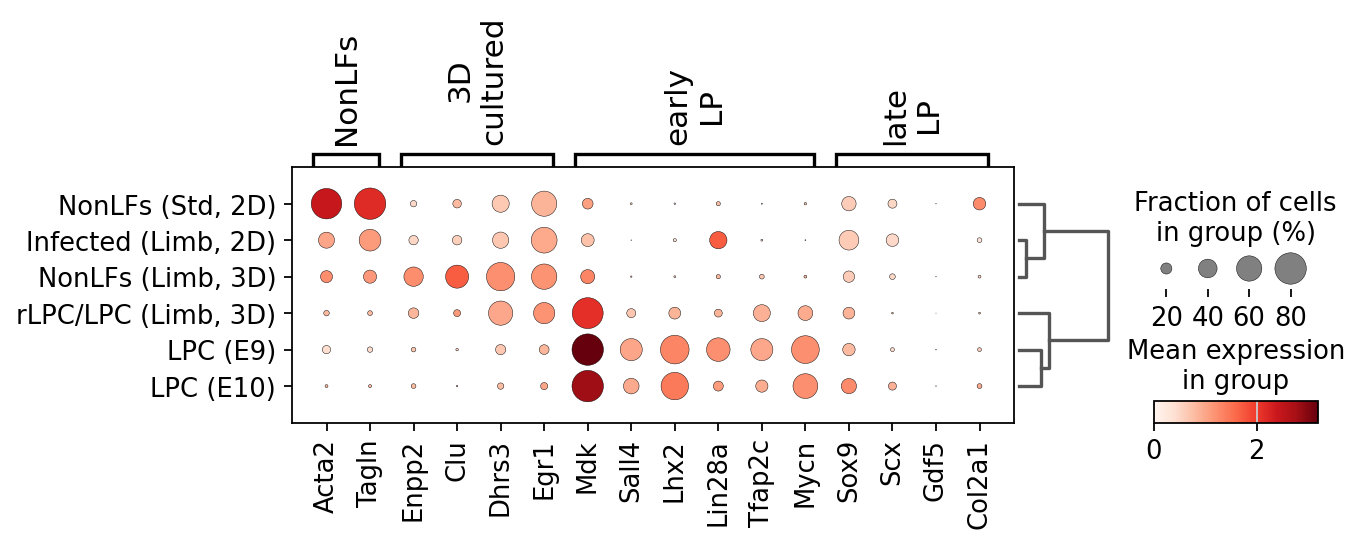

In [68]:
markers_genes_dict = {
    'NonLFs': ['Acta2','Tagln'],
    '3D\ncultured' : ['Enpp2','Clu','Dhrs3',
                      'Egr1'],
    'early\nLP': ['Mdk','Sall4', 'Lhx2', 'Lin28a', 
                  #'Trim71',
                  'Tfap2c', 'Mycn'],
    'late\nLP': ['Sox9', 'Scx', 'Gdf5', 'Col2a1']
}

sc.pl.dotplot(
    bdata, 
    var_names=markers_genes_dict, 
    groupby='label.0.2.reannotated', 
    var_group_labels=None,
    dendrogram=True, 
    mean_only_expressed=True,
    dot_max=0.8,
    save='Figure3B(right).png'
)

## Figure 3C

Understand specifically for the cluster=2, differentiation between primary and reprogrammed cells

In [69]:
bdata_subset = bdata[bdata.obs['integrated_snn_res.0.2'].isin(['2'])]
bdata_subset = bdata_subset[bdata_subset.obs['condition3'].isin(['cLPC','Primary','3F'])]
#bdata_subset = bdata_subset[~bdata_subset.obs['free.annotation2'].isin(['D02F0', 'D04F0', 'D08F0', 'D14F0', 'E10.5 (Scx+)', 'E11.5 (Scx+)', 'E11.5 (Tcf4+)', 'E11.5 (Tcf4+fibro)', 'E12.5', 'E12.5 (Osr1+)', 'NonLFs', 'NonLFs (3D)'])]
temp = bdata_subset.obs

In [70]:
bdata_subset = bdata_subset[bdata_subset.obs['condition3'].isin(['cLPC','3F'])]

bdata_subset.obs['primary'] = 'rLPCs in 3D culture (rLPC/LPC cluster)'
bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['cLPC'])] = 'E9-10 LPCs in 3D culture (rLPC/LPC cluster)'
# bdata_subset.obs['primary'][bdata_subset.obs['free.annotation2'].isin(['cultured E9.5FL', 'cultured E10.5HL'])] = 'E9-10 LPCs in 3D culture (rLPC/LPC cluster)'
# bdata_subset.obs['primary'][bdata_subset.obs['free.annotation2'].isin(['Limb field(?)', 'E9.0', 'E9.5', 'E10.0', 'E10.5'])] = 'E9-10 LPCs isolated (rLPC/LPC cluster)'
#bdata_subset.obs['primary'][bdata_subset.obs['free.annotation2'].isin(['D04PZL', 'D08PZL', 'D14PZL', 'D14PZL(HA.1) (negative)', 'D14PZL(HA.1) (positive)', 'D14PZL(HA.2) (negative)', 'D14PZL(HA.2) (positive)'])] = 'PZL cells (rLPC/LPC (3D) cluster)'
temp = bdata_subset.obs

/tmp/ipykernel_25688/2425321833.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_subset.obs['primary'] = 'rLPCs in 3D culture (rLPC/LPC cluster)'
/tmp/ipykernel_25688/2425321833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['cLPC'])] = 'E9-10 LPCs in 3D culture (rLPC/LPC cluster)'


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_tidy.mask(~obs_bool).groupby(level=0).mean().fillna(0)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatte

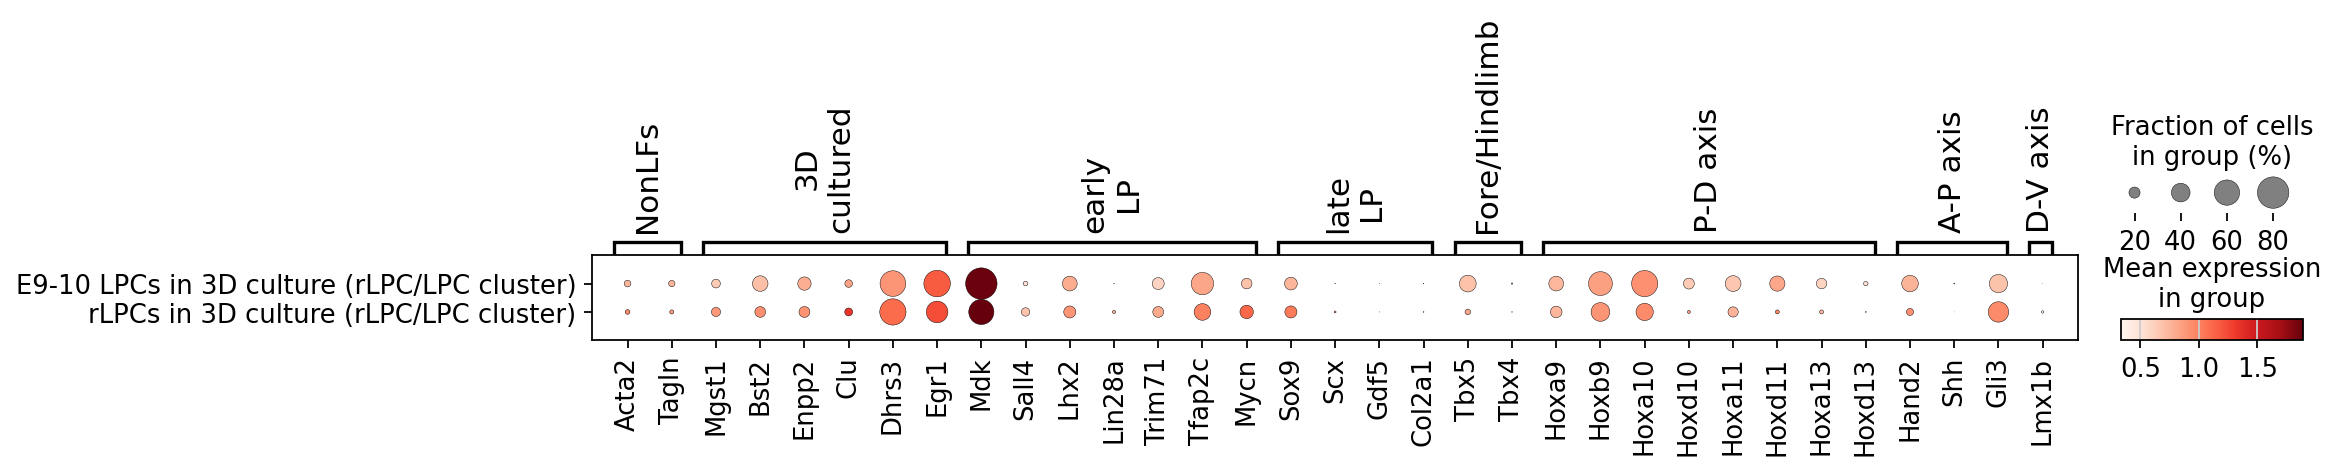

In [71]:
markers_genes_dict = {
    'NonLFs': ['Acta2','Tagln'],
    '3D\ncultured' : ['Mgst1', 'Bst2','Enpp2','Clu','Dhrs3','Egr1'],
#    'Transgenes' : ['Prdm16', 'Zbtb16', 'hLin41'],
    'early\nLP': ['Mdk','Sall4', 'Lhx2', 'Lin28a', 'Trim71','Tfap2c', 'Mycn'],
    'late\nLP': ['Sox9', 'Scx', 'Gdf5', 'Col2a1'],
    'Fore/Hindlimb': ['Tbx5', 'Tbx4'],
    'P-D axis': ['Hoxa9','Hoxb9','Hoxa10','Hoxd10','Hoxa11','Hoxd11','Hoxa13','Hoxd13'],
    'A-P axis': ['Hand2', 'Shh', 'Gli3'],
    'D-V axis': ['Lmx1b'],
}

sc.pl.dotplot(
    bdata_subset, 
    var_names=markers_genes_dict, 
    groupby='primary', 
    var_group_labels=None,
    dendrogram=False, 
    mean_only_expressed=True,
    dot_max=0.8,
    save='Figure3C3.png'
)

## Figure S3J

categories: NonLFs (Limb, 3D), rLPC/LPC (Limb, 3D), NonLFs (Std, 2D), etc.
var_group_labels: Fore/Hindlimb, P-D axis, A-P axis, etc.


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_tidy.mask(~obs_bool).groupby(level=0).mean().fillna(0)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatte

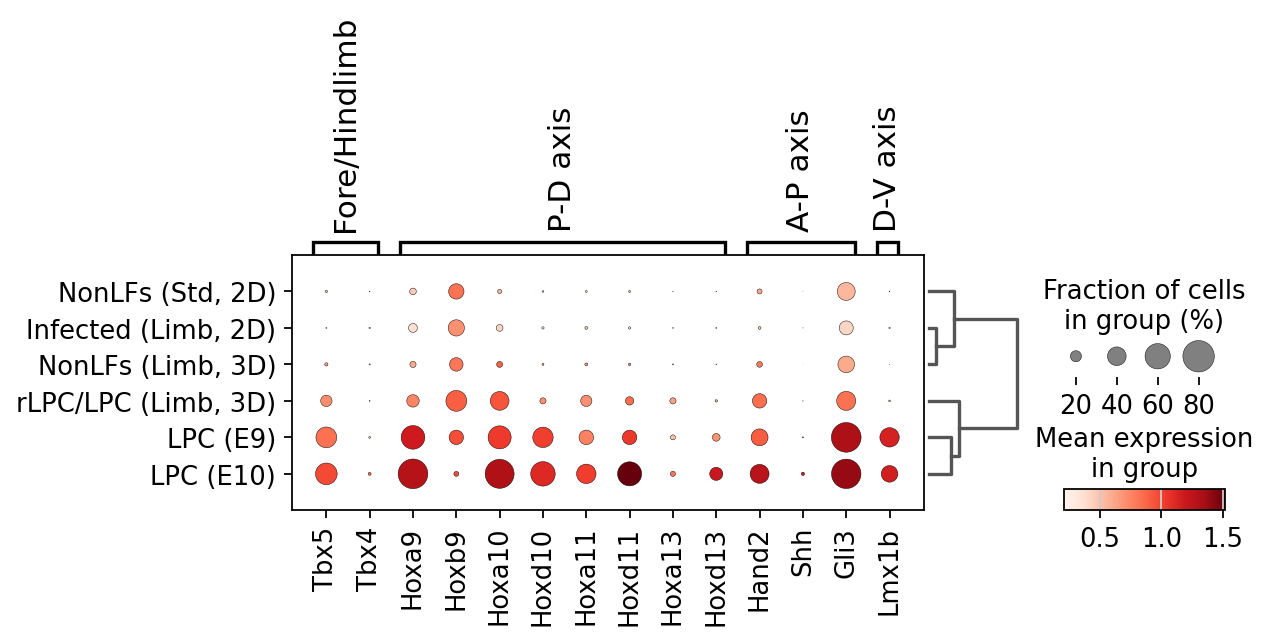

In [72]:
markers_genes_dict2 = {
    'Fore/Hindlimb': ['Tbx5', 'Tbx4'],
    'P-D axis': ['Hoxa9','Hoxb9','Hoxa10','Hoxd10','Hoxa11','Hoxd11','Hoxa13','Hoxd13'],
    'A-P axis': ['Hand2', 'Shh', 'Gli3'],
    'D-V axis': ['Lmx1b'],
}

sc.pl.dotplot(
    bdata, 
    markers_genes_dict2, 
    groupby='label.0.2.reannotated', 
    dendrogram=True, 
    mean_only_expressed=True,
#    dot_max=0.5,
    save='FigureS10D.png'
)

# Figure 4



In [5]:
bdata_var=ad.read_h5ad(data_dir + '20231001_mouse_pzlonly_combat_stringent.h5ad')

In [6]:
bdata_var.shape

(80039, 1797)

In [27]:
%%R

viridis.color <- viridisLite::viridis(n=7, alpha = 0.7, begin = 0, end = 0.9, direction = 1, option = "C")
stratum.color <- c(
    "NLF" = viridis.color[1],
    "N1" = viridis.color[1],
    "I"  = viridis.color[2],
    "N2"  = viridis.color[2],
#    "A2"  = viridis.color[2],
    "T"  = viridis.color[3],
    "N3"  = viridis.color[3],
    "Fail"  = viridis.color[3],
#    "F2"  = viridis.color[3],
#    "T3"  = viridis.color[3],
#    "r1"  = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[1],
#    "r2"  = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[2],
    "rLPC"  = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[3],
    "E09" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[4],
    "E10" = viridis.color[5],
#    "E11" = viridis.color[6],
#    "E12" = viridis.color[7],
    "Other" = "grey"
)
#strip.color <- viridis.color[c(2, 3, 3, 3, 4, 4, 4, 5)]
#strip.color <- stratum.color[c("A2", "T2", "T1", "T3", "r1", "r2", "r3", "E9")]
#strip.color <- stratum.color[c("I", "T", "rLPC", "E09", "E10")]
strip.color <- stratum.color[c("N2", "N3", "rLPC", "E09", "E10")]

## Compute gene signature scores (exclude cultured limb progenitors)

Here the .gmx file seems to be OK to start as is, although I should add in some other genesets such as chondrocyte differentiation, tendon development, limb development?

https://www.gsea-msigdb.org/gsea/msigdb/genesets.jsp is the place to go.
* GO_LIMB_BUD_FORMATION
* GO_EMBRYONIC_FORELIMB_MORPHOGENESIS
* GO_EMBRYONIC_HINDLIMB_MORPHOGENESIS
* GO_FORELIMB_MORPHOGENESIS
* GO_HINDLIMB_MORPHOGENESIS
* GO_CONNECTIVE_TISSUE_DEVELOPMENT
* GO_CHONDROCYTE_DEVELOPMENT 
* GO_CHONDROCYTE_DIFFERENTIATION 
* GO_TENDON_DEVELOPMENT 



In [86]:
gs = wot.io.read_sets(data_dir + '20210118_curated_gene_sets.gmx', bdata_var.var.index.values)
gs.var.description

MEF.identity                                 
Pluripotency                                 
Cell.cycle                                   
ER.stress                                    
Epithelial.identity                          
ECM.rearrangement                            
Apoptosis                                    
SASP                                         
Long-term MEFs                               
Embryonic mesenchyme                         
GO_TENDON_DEVELOPMENT                        
GO_EMBRYONIC_SKELETAL_JOINT_DEVELOPMENT      
GO_CARTILAGE_DEVELOPMENT                     
GO_CHONDROCYTE_DEVELOPMENT                   
GO_CONDROCYTE_DIFFERENTIATION                
GO_BONE_CELL_DEVELOPMENT                     
GO_LIMB_BUD_FORMATION                        
GO_EMBRYONIC_FORELIMB_MORPHOGENESIS          
GO_EMBRYONIC_HINDLIMB_MORPHOGENESIS          
GO_MYOFIBROBLAST_DIFFERENTIATION             
GO_FIBROBLAST_MIGRATION                      
GO_FIBROBLAST_PROLIFERATION       

In [87]:
# Calculate z-scores for the whole set

gene_set_scores_df = pd.DataFrame(index=bdata_var.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=bdata_var, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] = result['score']

gene_set_scores_df.to_csv(data_dir + '20231001_gene_set_scores_pzlonly_combat.csv', index_label='id')

## Survey clusters and prepare subsets

In [7]:
bdata_raw = ad.read_h5ad(data_dir + '20231001_pzlonly_init.h5ad')


In [8]:
bdata = ad.read_h5ad(data_dir + '20231001_mouse_pzlonly_combat_stringent.h5ad')

In [9]:
file_name_prefix = '20231001_tmaps_combat_pzlonly2'

print(file_name_prefix)

20231001_tmaps_combat_pzlonly2


In [10]:
bdata.obs['days'] = bdata.obs['day3'].astype(int)
# bdata.obs['days'] = bdata.obs['days'].apply(lambda x: 0 if x == 18 else x) 
bdata_raw.obs['days'] = bdata.obs['day3'].astype(int)
# bdata_raw.obs['days'] = bdata.obs['days']

# Generate datasets where NonLF is the starting point...

PZL   = (bdata.obs['condition3'] == '3F') | ((bdata.obs['condition3'] == '0F') & (bdata.obs['day3'] == '00'))

bdata_PZL   = bdata[PZL.values]

# For DEG
bdata_raw_PZL   = bdata_raw[PZL.values]



## Generate transport map

In [99]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv(data_dir + '20231001_gene_set_scores_pzlonly_combat.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
# growth_rates_df.to_csv(data_dir + 'wot_data/20210118_growth_gs_init_combat.txt')



In [100]:
# gene_set_scores[bdata.obs['factors2'].isin(['NonLFs','PZL']).values]
gene_set_scores_PZL   = gene_set_scores[PZL.values]

########
# PZL
########

proliferation=gene_set_scores_PZL['Cell.cycle']
apoptosis = gene_set_scores_PZL['Apoptosis']

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df_PZL = pd.DataFrame(index=gene_set_scores_PZL.index, data={'cell_growth_rate':gr})




In [101]:
bdata_PZL.obs['cell_growth_rate']   = growth_rates_df_PZL['cell_growth_rate'].values

/tmp/ipykernel_25688/1177724549.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_PZL.obs['cell_growth_rate']   = growth_rates_df_PZL['cell_growth_rate'].values


In [102]:
bdata_PZL.write(data_dir + '20231001_mouse_pzlonly_combat_stringent_PZL.h5ad')

In [103]:
bdata_PZL = ad.read_h5ad(data_dir + '20231001_mouse_pzlonly_combat_stringent_PZL.h5ad')

In [104]:
bdata_PZL.obs['days'].unique()

array([ 4,  0, 14,  3,  2, 10,  8])

In [105]:
# about total ~30 minutes
ot_model_PZL = wot.ot.OTModel(bdata_PZL,epsilon = 0.05, lambda1 = 1,lambda2 = 50,growth_iters=3, day_field = 'days')  
ot_model_PZL.compute_all_transport_maps(tmap_out=data_dir + 'wot_data/' + file_name_prefix + '_PZL')


## Establish cell sets & Transition table (resolution=0.2)


In [11]:
file_name_prefix = '20231001_tmaps_combat_pzlonly2'

print(file_name_prefix)

20231001_tmaps_combat_pzlonly2


In [12]:
cluster_labels = {
    '1'  : 'T',
    '4'  : 'E10',
    '2'  : 'rLPC',
    '3'  : 'NLF',
    '5'  : 'E09',
    '6'  : 'I',
}

In [13]:
cell_sets_PZL = {}

for c in ['1','2','3','4','5','6']: 
    print(f'number: {c}, {cluster_labels[c]}')
    cell_sets_PZL[cluster_labels[c]]   = bdata_PZL[bdata_PZL.obs['integrated_snn_res.0.2'] == c].obs.index.tolist()
    print(f'PZL cell size:{len(cell_sets_PZL[cluster_labels[c]])}')
    


number: 1, T
PZL cell size:17695
number: 2, rLPC
PZL cell size:9279
number: 3, NLF
PZL cell size:13625
number: 4, E10
PZL cell size:95
number: 5, E09
PZL cell size:58
number: 6, I
PZL cell size:685


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated,

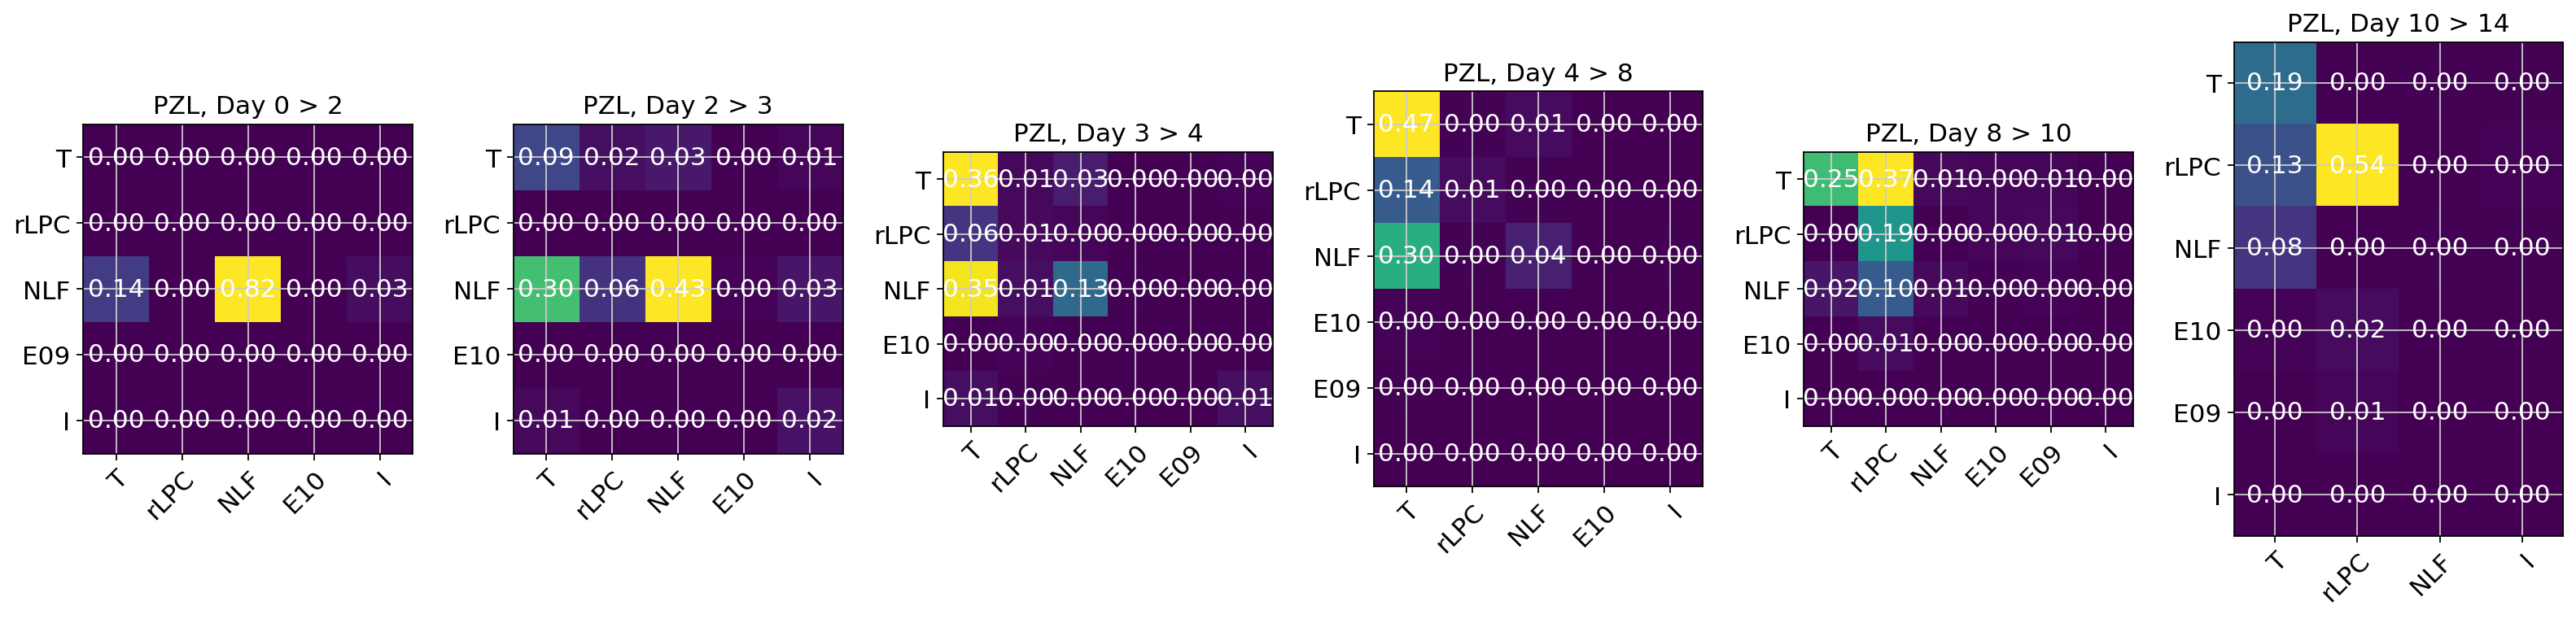

In [17]:
# Time intervals to generate transport matrices
time_intervals = [(0, 2), (2, 3), (3, 4), (4, 8), (8, 10), (10, 14)]

# Load the transport map model
tmap_model_PZL = wot.tmap.TransportMapModel.from_directory(data_dir + 'wot_data/' + file_name_prefix + '_PZL')

# Initialize a list to store the transition tables for plotting
transition_tables = []

# Loop through each time interval
for start_time, end_time in time_intervals:
    # Compute the start and end populations for the current interval
    start_populations = tmap_model_PZL.population_from_cell_sets(cell_sets_PZL, at_time=start_time)
    end_populations = tmap_model_PZL.population_from_cell_sets(cell_sets_PZL, at_time=end_time)

    # Compute the transition table for the current interval
    transition_table = tmap_model_PZL.transition_table(start_populations, end_populations)

    # Save the transition table to a TSV file
    pd.DataFrame(
        transition_table.X,
        columns=transition_table.var.index,
        index=transition_table.obs.index
    ).to_csv(data_dir + 'wot_data/' + file_name_prefix + f'_PZL_res0.2_{start_time}_to_{end_time}.tsv', sep='\t', index_label="source")

    # Store the transition table for plotting
    transition_tables.append(transition_table)

# Plot all matrices
fig, axes = plt.subplots(1, len(transition_tables), figsize=(20, 8))

for i, transition_table in enumerate(transition_tables):
    im = axes[i].imshow(transition_table.X)
    axes[i].set_title(f'PZL, Day {time_intervals[i][0]} > {time_intervals[i][1]}')
    axes[i].set_xticks(np.arange(len(transition_table.var_names)))
    axes[i].set_yticks(np.arange(len(transition_table.obs_names)))
    axes[i].set_xticklabels(transition_table.var_names)
    axes[i].set_yticklabels(transition_table.obs_names)
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Create text annotations
    for x in range(transition_table.shape[0]):
        for y in range(transition_table.shape[1]):
            axes[i].text(y, x, '{:.2f}'.format(transition_table.X[x, y]),
                         ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

## Figure 4A

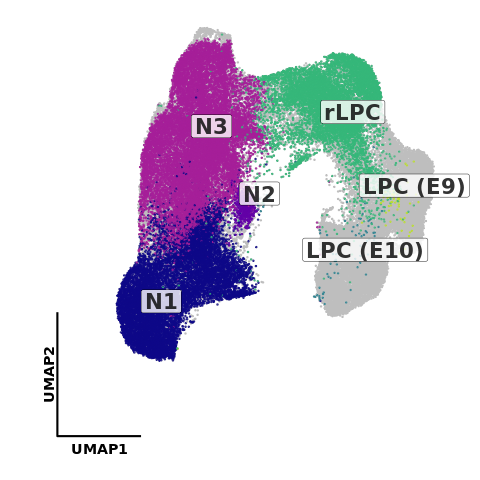

In [23]:
%%R

Figure4A.inset <-
ggplot() +
  geom_point( 
    data=FetchData( integrated, vars = c("UMAP_1", "UMAP_2"  ) ),
    aes(x = UMAP_1, y = UMAP_2),
    size = 0.5,
    colour = "grey"
  ) +
  geom_point( 
    data=FetchData( integrated, vars = c("UMAP_1", "UMAP_2", "cluster.order.0.2", "day3", "condition3" ) )  %>%
            dplyr::filter( condition3 %in% c("3F") | (condition3 %in% c("0F") & day3 %in% c("00"))) %>%
            arrange(
                sample(1:n())
#               factor(
#                 cluster.order.0.2,
#                 levels = (cluster.order)
#               )
            ),
    aes(x = UMAP_1, y = UMAP_2, colour = cluster.order.0.2),
    size = 0.5
  ) +
  cowplot::theme_cowplot() +
  ggrepel::geom_label_repel(
    data=FetchData(
            integrated,
            vars = c("UMAP_1", "UMAP_2", "label.0.2", "condition3" )
        ) %>%
        group_by( label.0.2 ) %>%   # TODO
        summarize(
            across(
                UMAP_1:UMAP_2,
                ~mean(.x)
            )
        ) %>%
        mutate(
            label.0.2.abbreviated = case_when(
                label.0.2 == "NonLF\nStandard Culture (2D)" ~ "N1",
                label.0.2 == "NonLF\nLimb Culture (2D)" ~ "N2",
                label.0.2 == "NonLF\nLimb Culture (3D)" ~ "N3",
                label.0.2 == "rLPC/LPC\nLimb Culture (3D)" ~ "rLPC",
                TRUE ~ label.0.2
            )
        ),
    aes( 
      x = UMAP_1, 
      y = UMAP_2, 
      label = label.0.2.abbreviated
    ),
    size = 7.5,
    fontface = "bold",
    alpha = 0.8
  ) +
  scale_x_reverse( expand = expansion(0.1, 0)) +
# UMAP axis plot
  geom_line(
    data = axis.data,
    inherit.aes = F,
    aes( x = -x, y = y ),
    linewidth = 1
  ) +
  annotate(
    "text", 
    x = 9.5, 
    y = -10.5, 
    label = "UMAP1", 
    hjust = 0.5, # center justified
    vjust = 0.5, # center justified
    fontface = "bold",
    size = 5
  ) +
  annotate(
    "text", 
    x = 12.5,
    y = -7.5,
    label = "UMAP2", 
    vjust = 0.5, # center justified
    hjust = 0.5, # center justified
    angle = 90,
    fontface = "bold",
    size = 5
  ) +
#  scale_colour_viridis_d( option = "C", end = 0.9 ) +
#   scale_colour_manual( 
#     values= cluster.color
#   ) +  
  scale_colour_manual(
      values = cluster.color
#           c(
# #           cluster.order   # Somehow scale_colour_manual does not work with a variable!
#             "3" = viridis.color[1],
#             "6" = viridis.color[2],
#             "1" = viridis.color[3],
#             "2" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[3],
#             "5" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[4],
#             "4" = viridisLite::viridis(n=4, alpha = 0.7, begin = 0.2, end = 0.9, direction = 1, option = "D")[2]
#           )
  ) +
#   scale_fill_manual( 
#     values= cluster.color
#   ) +  
  theme( 
    axis.ticks   = element_blank(),
    axis.title   = element_blank(),
    axis.text    = element_blank(),
    axis.line    = element_blank(),
    panel.grid   = element_blank(),
    panel.border = element_blank(),
    legend.position = "none"
  )

options(repr.plot.width=7, repr.plot.height=7)
Figure4A.inset


`summarise()` has grouped output by 'trajectory', 'day1'. You can override
using the `.groups` argument.
0.115 sec elapsed
0.165 sec elapsed
0.083 sec elapsed


Error in grid.Call(C_convert, x, as.integer(whatfrom), as.integer(whatto),  : 
  Viewport has zero dimension(s)
In addition: Warning messages:
1: In left_join(., table_list[[i]], by = c("trajectory", join_col)) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.
2: In left_join(., table_list[[i]], by = c("trajectory", join_col)) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.
3: In left_join(., table_list[[i]], by = c("trajectory", join_col)) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple r

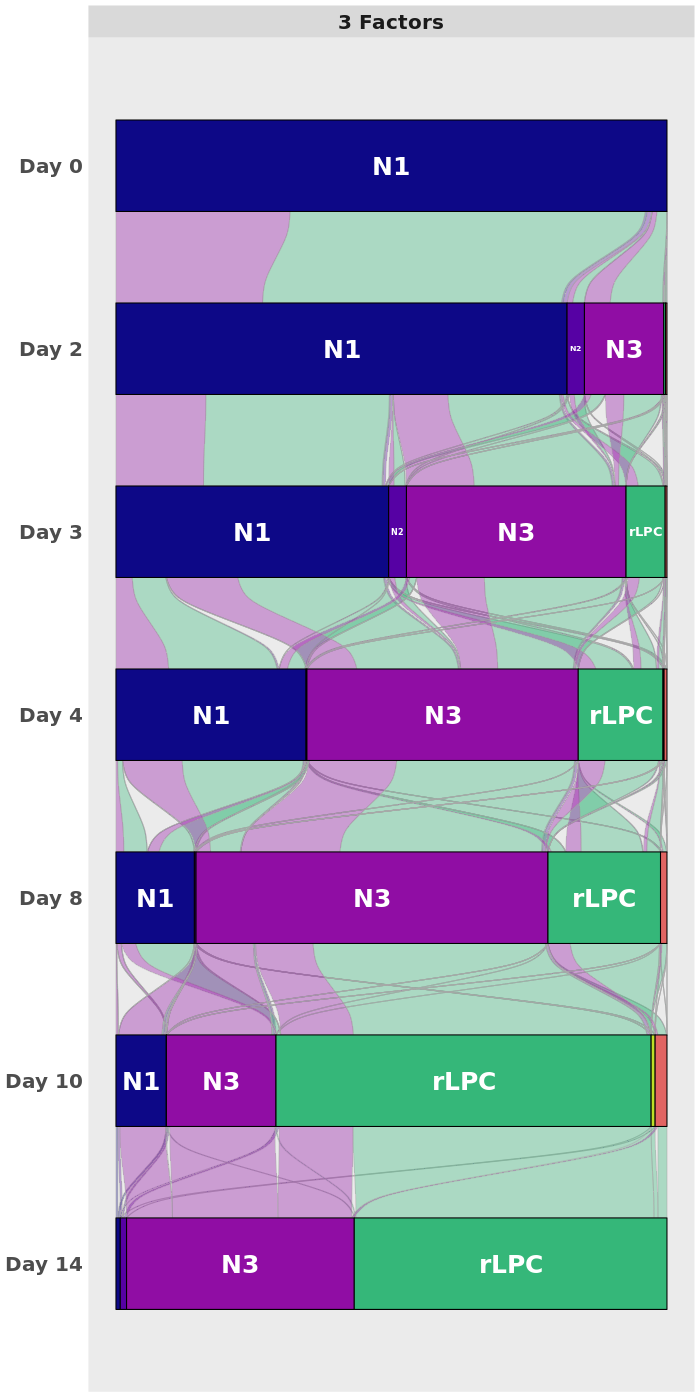

In [31]:
%%R -i file_name_prefix -w 700 -h 1400

transition_days <- c(0, 2, 3, 4, 8, 10, 14)

# Generate the transition matrix with necessary transitions
transitions <-
crossing(
    tibble(
        day1 = transition_days[-length(transition_days)],
        day2 = transition_days[-1]
    ),
    tibble(
        trajectory = c("PZL")
    )
) %>%
rowwise() %>%
mutate(
    matrix = list(
        read_tsv(
            glue::glue("{data.dir}/wot_data/{file_name_prefix}_{trajectory}_res0.2_{day1}_to_{day2}.tsv"),
            col_types = cols()  # suppress messages by opting to use the guessing behavior
        )
    )
) %>%
unnest(matrix) %>%
pivot_longer(
    cols = -c(day1, day2, trajectory, source),
    names_to  = "dest",
    values_to = "probability"
) %>%
dplyr::filter(!is.na(probability)) %>%
dplyr::select( trajectory, source, day1, dest, day2, probability )

# Calculate the growth fraction (normalization factor from transition matrix)
gf <- 
transitions %>%
dplyr::filter( day1 != 0 | (day1 == 0 & source == "NLF") ) %>%
group_by( trajectory, day1, source ) %>%
summarize( fraction = sum(probability)) %>%
pivot_wider(
    names_from = day1,
    names_prefix = "tp",
    values_from = fraction,
    values_fill = 0
) %>%
group_by( trajectory ) %>%
mutate( across(starts_with("tp"), ~.x / sum(.x, na.rm = T)) ) %>%
pivot_longer(
    cols = starts_with("tp"),
    names_to = "days",
    values_to = "fraction"
) %>%
pivot_wider( 
    names_from = source,
    values_from = fraction,
    values_fill = 0
) %>%
pivot_longer(
    cols = -c("trajectory", "days"),
    names_to = "cluster",
    values_to = "fraction"
)

# Each transition probability normalized by total of that transition
tictoc::tic()
table_list <- list()

table_list[[1]] <-
transitions %>%
dplyr::filter( 
    day1 == transition_days[1], 
    day2 == transition_days[2], 
    source == "NLF" # anchor start with NLF
) %>%
dplyr::select( trajectory, source, dest, probability ) %>%
dplyr::rename(
    !!paste0("tp", transition_days[1]) := source,
    !!paste0("tp", transition_days[2]) := dest
) %>%
group_by( trajectory, !!paste0("tp", transition_days[1]) ) %>%
mutate(
    probability = probability / sum(probability, na.rm = TRUE )
) %>%
ungroup()


for (i in 2:(length(transition_days) - 1)) {
    table_list[[i]] <-
    transitions %>%
    dplyr::filter( 
        day1 == transition_days[i], 
        day2 == transition_days[i+1]
    ) %>%
    dplyr::select( trajectory, source, dest, probability ) %>%
    dplyr::rename(
        !!paste0("tp", transition_days[i]) := source,
        !!paste0("tp", transition_days[i+1]) := dest
    ) %>%
    group_by( trajectory, !!paste0("tp", transition_days[i]) ) %>%
    mutate(
        probability = probability / sum(probability, na.rm = TRUE )
    ) %>%
    ungroup()
    
}
tictoc::toc()

# Initialize test as the first table
tictoc::tic()
test <- table_list[[1]]

# Loop through the remaining tables to join them together
for (i in 2:length(table_list)) {
  # Define suffixes for renaming
  suffixes <- c(paste0(".tp", transition_days[i-1]), paste0(".tp", transition_days[i]))

  # Define the join column name
  join_col <- paste0("tp", transition_days[i])

  # Rename the probability column in the next table before joining
  table_list[[i]] <- table_list[[i]] %>%
    dplyr::rename(
      !!paste0("probability.tp", transition_days[i]) := probability
    )

  test <- test %>%
    left_join(
      table_list[[i]],
      by = c("trajectory", join_col)
    )
}
tictoc::toc()
        
# Now adjust with growth fraction and calculate total probability
tictoc::tic()
test <- 
  test %>%
  rownames_to_column("flow") %>%
  mutate(
    highlight = !!sym(paste0("tp", max(transition_days))),
    p = Reduce(`*`, across(starts_with("probability")))
  ) %>%
  dplyr::select(trajectory, flow, everything(), -starts_with("probability")) %>%
  pivot_longer(
    cols = starts_with("tp"),
    names_to = "days",
    values_to = "cluster"
  ) %>%
  select(trajectory, flow, days, cluster, p, highlight) %>%
  left_join(
    gf,
    by = c("trajectory", "days", "cluster")
  ) %>%
  group_by(trajectory, days, cluster) %>%
  mutate(
    adjust.p = p * fraction / sum(p, na.rm = TRUE)
  ) %>%
  ungroup() %>%
  tidyr::fill(adjust.p)
tictoc::toc()

####### Visualization Code ##############
library(ggalluvial)

Figure4A <-
test %>%
#filter( !is.na(adjust.p) ) %>%
mutate(
    Date = factor( 
        gsub("^tp", "Day ", days), 
        levels = rev( 
            paste0( "Day ", transition_days )
        )
    ),
    # This is to correct the notation mismatch
    cluster = case_when(
        cluster == "NLF" ~ "N1",
        cluster == "I" ~ "N2",
        cluster == "T" ~ "N3",
        TRUE ~ cluster
    ),
    cluster = factor( 
        cluster, 
        levels = rev(names(stratum.color))
    ),
    trajectory2 = "3 Factors"
) %>%
ggplot(
    aes(x = Date, stratum = cluster, alluvium = flow, y = adjust.p, label = cluster )
) +
scale_x_discrete( expand = c(.1, .1) ) +
geom_flow( width = 0.5, colour = "darkgrey", aes( fill = highlight ) ) +
geom_stratum( alpha = 1.0, width = 0.5, aes( fill = cluster ) ) +
ggfittext::geom_fit_text(
    stat = "stratum", 
    aes( label = after_stat(stratum) ), 
    size = 25, 
    fontface = "bold",
    contrast = T
) +
# labs( x = "Days after infection and 3D culture" ) +
scale_fill_manual(
  values = stratum.color
) +
facet_wrap( trajectory2 ~ . ) +
coord_flip() +
theme(
    panel.grid   = element_blank(),
    panel.border = element_blank(),
    legend.position = "none",
#    legend.position = "bottom",
#    legend.direction = "horizontal",
#    legend.justification = "center", 
#    legend.title    = element_blank(),
#    legend.text.align = 0.5,
#    legend.text  = element_text( size = 20, face = "bold" ),
    strip.text.y.left = element_text(angle = 0, size = 20, face="bold", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    strip.text.x.top  = element_text(angle = 0, size = 20, face="bold", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    axis.text.x     = element_blank(),
    axis.text.y     = element_text( size = 20, face = "bold" ),
    axis.title    = element_blank(),
#    axis.title.y    = element_text( size = 20, margin = margin(5, 5, 5, 5)),
    axis.ticks      = element_blank(),
    axis.line       = element_blank()
)

options( repr.plot.width = 7, repr.plot.height = 14 ) # this setting does not work in rpy2 environment
Figure4A

## Figure 4B


In [63]:
bdata_PZL.obs['integrated_snn_res.0.2'].unique()

['1', '2', '3', '6', '5', '4']
Categories (6, object): ['1', '2', '3', '4', '5', '6']

In [56]:
cluster_labels = {
    '1'  : 'T',
    '4'  : 'E10',
    '2'  : 'rLPC',
    '3'  : 'NLF',
    '5'  : 'E09',
    '6'  : 'I',
}

In [57]:
print(file_name_prefix)

20231001_tmaps_combat_pzlonly2


In [69]:
cell_sets_PZL = {}

for c in cluster_labels.keys():  # exclude everything except the final two
    print(f'number: {c}, {cluster_labels[c]}')
    
    unique_combinations_PZL = bdata_PZL[
        (bdata_PZL.obs['integrated_snn_res.0.2'] == c) &
        (bdata_PZL.obs['day3'] == '14')
    ].obs['pseudobulk'].unique()
    for pseudobulk_value in unique_combinations_PZL:
        key = f'{cluster_labels[c]}_{pseudobulk_value}'
        
        temp = bdata_PZL[
            (bdata_PZL.obs['integrated_snn_res.0.2'] == c) & 
            (bdata_PZL.obs['day3'] == '14') &
            (bdata_PZL.obs['pseudobulk'] == pseudobulk_value)].obs.index.tolist()
        if len(temp) > 50:
            cell_sets_PZL[key] = temp
            print(f'PZL cell size ({key}):{len(cell_sets_PZL[key])}')

            
    

number: 1, T
PZL cell size (T_HA1-bulk):1181
PZL cell size (T_HA2-bulk):3685
number: 4, E10
number: 2, rLPC
PZL cell size (rLPC_rerepr_5-bulk):2922
PZL cell size (rLPC_HA1-bulk):3440
PZL cell size (rLPC_HA2-bulk):182
number: 3, NLF
PZL cell size (NLF_HA2-bulk):68
number: 5, E09
number: 6, I
PZL cell size (I_HA2-bulk):132


In [70]:
tmap_model_PZL   = wot.tmap.TransportMapModel.from_directory(data_dir + 'wot_data/' + file_name_prefix + '_PZL')

# This is already done above to restrict to pseudobulk population that has more than 50 cells.
end_populations_PZL     = tmap_model_PZL.population_from_cell_sets(
    cell_sets_PZL, 
    at_time=14
)

# This generates an AnnData with "day" field. Because of this specific results that is not changeable easily,
# the next step has to have some fix.
trajectory_ds_PZL = tmap_model_PZL.trajectories(
    end_populations_PZL  # This is only restricted to day=14 cells.
)

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated,

In [71]:
# This is the common error I encounter. the "day" column in the original file is STRING and has to be changed

# print(bdata_PZL.obs['day'].unique())
bdata_PZL.obs['day'] = bdata_PZL.obs['days'] # integer type conversion, this is a bug fix!
print(bdata_PZL.obs['day'].unique())


[ 4  0 14  3  2 10  8]


In [73]:
# 2.5 minutes
divergence_df_PZL = wot.tmap.trajectory_divergence(bdata_PZL, trajectory_ds_PZL, distance_metric='total_variation')

divergence_df_PZL

,name1,name2,day1,day2,distance
0,T_HA1-bulk,T_HA2-bulk,0.0,0.0,0.020046
1,T_HA1-bulk,T_HA2-bulk,2.0,2.0,0.055455
2,T_HA1-bulk,T_HA2-bulk,3.0,3.0,0.091202
3,T_HA1-bulk,T_HA2-bulk,4.0,4.0,0.163264
4,T_HA1-bulk,T_HA2-bulk,8.0,8.0,0.262768
...,...,...,...,...,...
142,NLF_HA2-bulk,I_HA2-bulk,3.0,3.0,0.165202
143,NLF_HA2-bulk,I_HA2-bulk,4.0,4.0,0.257446
144,NLF_HA2-bulk,I_HA2-bulk,8.0,8.0,0.354314
145,NLF_HA2-bulk,I_HA2-bulk,10.0,10.0,0.631568


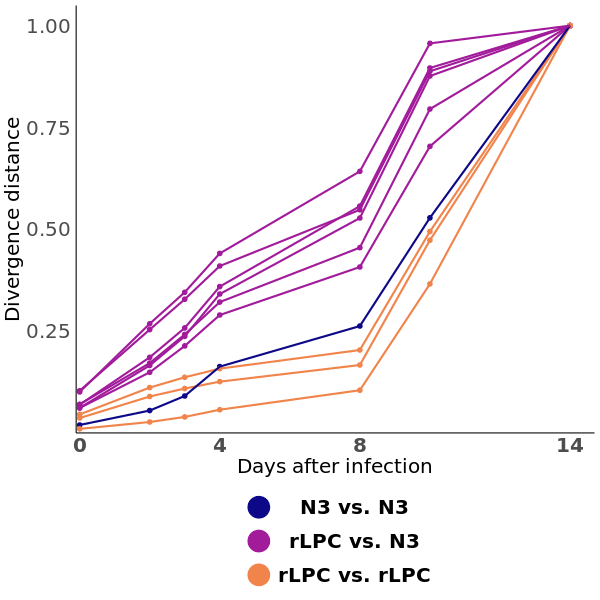

In [82]:
%%R -i divergence_df_PZL -w 600 -h 600

library(tidyverse)

# cluster_labels = {
#     '1'  : 'T',
#     '4'  : 'E10',
#     '2'  : 'rLPC',
#     '3'  : 'NLF',
#     '5'  : 'E09',
#     '6'  : 'I',
# }

divergence_df_PZL  %>% mutate( trajectory = "PZL" ) %>%
filter( trajectory == "PZL" ) %>%
mutate(
    name  = paste0( name1, " vs. ", name2 ),
    cluster1 = map_chr( name1, ~strsplit(.x, "_")[[1]][1]), 
    cluster2 = map_chr( name2, ~strsplit(.x, "_")[[1]][1]), 
    category1 = case_when(
        cluster1 %in% c( "T" )  ~ "N3",
        cluster1 %in% c( "rLPC" ) ~ "rLPC",
        TRUE ~ "Other"
    ),
    category2 = case_when(
        cluster2 %in% c("T" )  ~ "N3",
        cluster2 %in% c("rLPC" ) ~ "rLPC",
        TRUE ~ "Other"
    ),
    category = paste0( category1, " vs. ", category2 )
) %>%
dplyr::filter( 
    category1 %in% c("N3", "rLPC" ),
    category2 %in% c("N3", "rLPC" )
) %>%
mutate(
    category = ifelse( 
        category == "N3 vs. rLPC", 
        "rLPC vs. N3", 
        category 
    ),
    category = factor(
        category,
        levels = c("N3 vs. N3", "rLPC vs. N3", "rLPC vs. rLPC")
    )
) %>%
ggplot(aes(x = day2, y = distance, group = name, colour = category)) + 
geom_point( size = 2 ) +
geom_line( size = 1, show.legend = FALSE, aes( linetype = trajectory ) ) +
# facet_wrap( trajectory ~ . ) +
scale_x_continuous( 
    breaks = c(0, 4, 8, 14),
    expand = expansion( add = c(0.1,0), mult = c(0,0.05) )
) +
scale_y_continuous(
    expand = expansion( add = c(0.01,0), mult = c(0, 0.05) )
) +
labs(
    x = "Days after infection",
    y = "Divergence distance"
) +
scale_colour_viridis_d( name = "Sample Origin", option = "C", end = 0.7 ) +
guides(
    colour = guide_legend(
      override.aes =
        list(
          size  = 10,
          alpha = 1.0
        ),
      ncol= 1,
      byrow = T
    )
) +
theme_minimal() +
theme( 
    legend.position = "bottom",
    panel.grid   = element_blank(),
    panel.border = element_blank(),
    legend.direction = "horizontal",
    legend.justification = "center", 
    legend.title    = element_blank(),
    legend.text.align = 0.5,
    legend.text  = element_text( size = 20, face = "bold" ),
    strip.text.y.left = element_text(angle = 0, size = 20, face="bold", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    strip.text.x.top  = element_text(angle = 0, size = 20, face="bold", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    axis.text.x     = element_text( size = 20, face = "bold", hjust = 0.5 ),
    axis.text.y     = element_text( size = 20 ),
    axis.title      = element_text( size = 20, margin = margin(5, 5, 5, 5)),
    axis.line       = element_line(color = "black")
) 

## Figure 4C


In [83]:
cluster_labels = {
    '1'  : 'T',
    '4'  : 'E10',
    '2'  : 'rLPC',
    '3'  : 'NLF',
    '5'  : 'E09',
    '6'  : 'I',
}

In [84]:
print(file_name_prefix)

20231001_tmaps_combat_pzlonly2


In [85]:
cell_sets_PZL = {}

# This is what I am worried about. Will this marking actually work???
# Maybe using R here also would be safe after all....

for c in cluster_labels.keys():  # exclude everything except the final two
    print(f'number: {c}, {cluster_labels[c]}')
    cell_sets_PZL[cluster_labels[c]]   = bdata_PZL[bdata_PZL.obs['integrated_snn_res.0.2'] == c].obs.index.tolist()
    print(f'PZL cell size:{len(cell_sets_PZL[cluster_labels[c]])}')
    

number: 1, T
PZL cell size:17695
number: 4, E10
PZL cell size:95
number: 2, rLPC
PZL cell size:9279
number: 3, NLF
PZL cell size:13625
number: 5, E09
PZL cell size:58
number: 6, I
PZL cell size:685


In [86]:
tmap_model_PZL   = wot.tmap.TransportMapModel.from_directory(data_dir + 'wot_data/' + file_name_prefix + '_PZL')
target_cell_set_PZL = tmap_model_PZL.population_from_cell_sets( cell_sets_PZL, at_time=14 )

target_cell_set_PZL = tmap_model_PZL.population_from_cell_sets(
    {'rLPC':
     cell_sets_PZL['rLPC'],    
     'Fail':
     cell_sets_PZL['T'],
    }, at_time=14)


# Compute fate matrix for the final set
# Generates essentially a matrix with fate+1 column (+1 for Other), and all cells for the fraction ...
fate_ds_PZL   = tmap_model_PZL.fates(target_cell_set_PZL)        



/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated,

In [90]:
import pandas as pd

# Days to perform the analysis
days_to_analyze = [2, 3, 4, 8, 10]

# Initialize an empty list to store results for each day
all_results = []

# Iterate over the specified days
for day in days_to_analyze:
    # Subset the data for the specific day
    bdata_raw_PZL_day = bdata_raw[bdata_PZL.obs.index]
    bdata_for_day = bdata_raw_PZL_day[bdata_PZL.obs['days'] == day]

    # Perform differential expression analysis
    results_day = wot.tmap.diff_exp(
        bdata_for_day, 
        fate_ds_PZL, 
        compare='all', 
        cell_days_field='days'
    )

    # Reset index and rename columns
    results_day.reset_index(inplace=True)
    results_day = results_day.rename(columns={'index': 'feature'})

    # Filter and sort results
    filtered_results = results_day[
        (results_day['t_fdr'] < 0.01) &
        (results_day['name1'] == 'rLPC') &
        (results_day['name2'] == 'Fail')
    ].sort_values('fraction_expressed_ratio', ascending=False)

    # Add a column to indicate the day
    filtered_results['day'] = day

    # Append the results for this day to the list
    all_results.append(filtered_results)

# Concatenate all results into a single DataFrame
results_PZL = pd.concat(all_results, ignore_index=True)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-

In [92]:
# You can retrieve the saved file

results_PZL.to_csv( data_dir + 'wot_data/' + file_name_prefix + '_DEG.csv')

results_PZL = pd.read_csv(data_dir + 'wot_data/' + file_name_prefix + '_DEG.csv')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 4400 rows containing missing values (`geom_point()`). 



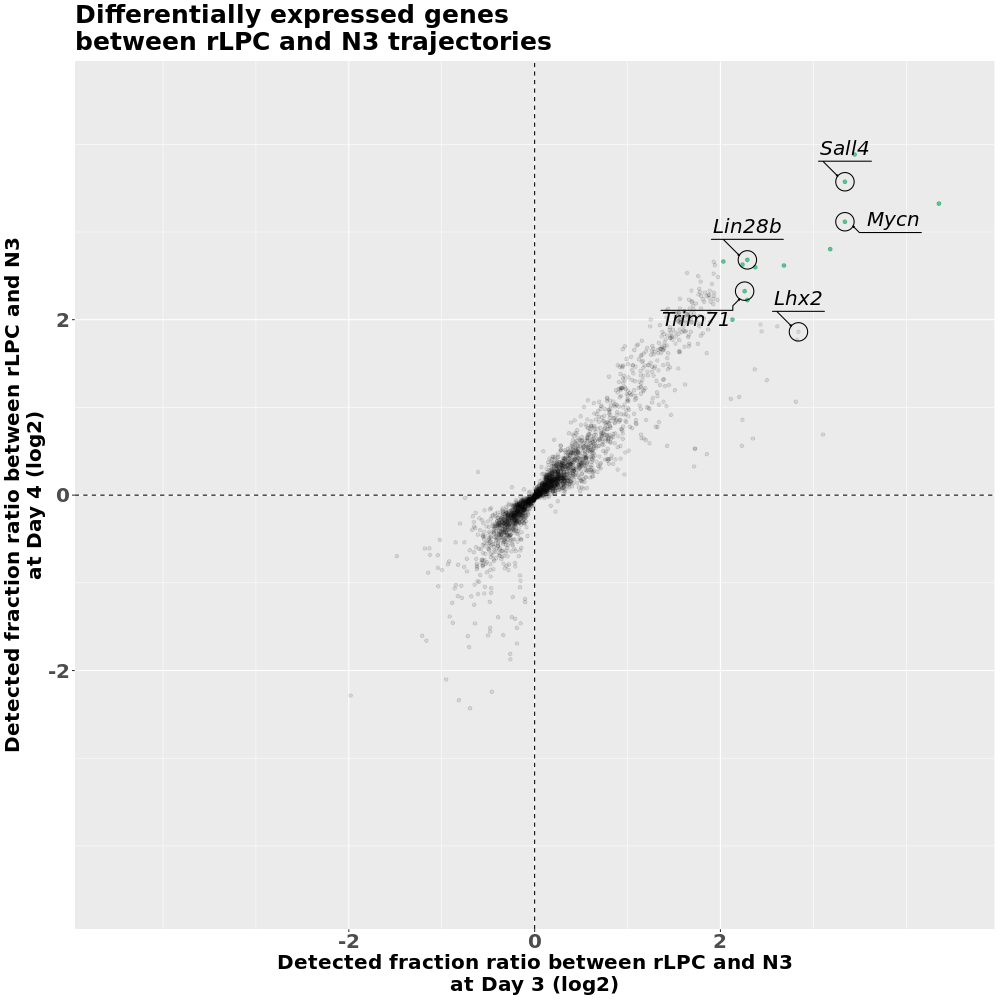

In [94]:
%%R -i results_PZL -w 1000 -h 1000

Figure4C <-
results_PZL %>%
dplyr::filter( 
    t_fdr < 0.01, 
    feature %ni% c("EGFP"),
    name1 == "rLPC", name2 == "Fail",
#    abs(log2(fraction_expressed_ratio)) > 2,
    day1 %in% c(3,4)
) %>%
mutate(
    log2_fraction_exressed_ratio = log2( fraction_expressed_ratio )
) %>%
dplyr::select( feature, log2_fraction_exressed_ratio, day1 ) %>%
pivot_wider( names_from = day1, names_prefix = "Day ", values_from = log2_fraction_exressed_ratio ) %>% {
    ggplot( ., aes( x = `Day 3`, y = `Day 4` ) ) +
    geom_point( alpha = 0.1 ) +
    geom_point( 
        data = . %>% 
        filter( 
            `Day 3` > 2,
            `Day 4` > 2
        ), 
        colour = stratum.color["rLPC"]
    ) +
#    geom_abline( linetype = "dashed", colour = "salmon" ) +
#     geom_hline( linetype = "dashed", colour = "salmon", yintercept = 2.5 ) +
#     geom_vline( linetype = "dashed", colour = "salmon", xintercept = 2.5 ) +
    ggforce::geom_mark_circle(
        data = . %>%
        filter(
#            ((`Day 3` > 2.5 ) & ( `Day 4` > 2.5 )) |
            ( feature %in% c( "Sall4", "Mycn", "Lhx2", "Trim71", "Lin28b" ) )
        ),
        aes( 
          label = feature,
          group = feature
        ),
        alpha = 1,
        expand = 0.01,
        con.cap = unit(0, "mm"),
        con.type = "elbow",
        con.arrow = arrow( 
          length = unit(0.5, "mm"),
          ends = "last", 
          type = "closed" 
        ),
        label.buffer = unit(2, 'mm'),
        label.margin = margin(0.5, 0.5, 0.5, 0.5, "mm"),
        label.fontsize = 20,
        label.fontface = "italic",
        label.fill = NA
    ) +
    geom_hline( yintercept = 0, linetype = "dashed" ) +
    geom_vline( xintercept = 0, linetype = "dashed" ) +
    scale_x_continuous( lim = c(-4.5, 4.5), breaks = c(-2, 0, 2) ) +
    scale_y_continuous( lim = c(-4.5, 4.5), breaks = c(-2, 0, 2) ) +
    labs(
        title = "Differentially expressed genes\nbetween rLPC and N3 trajectories",
        x = "Detected fraction ratio between rLPC and N3\nat Day 3 (log2)", 
        y = "Detected fraction ratio between rLPC and N3\nat Day 4 (log2)"
    ) +
    theme(
    #    legend.position = "right",
    #    legend.title = element_blank(),
    #    legend.title = element_text( size = 20, face = "bold"),
    #    legend.text  = element_text( size = 15 ),
        axis.title   = element_text( size = 20, face = "bold" ),
        axis.text    = element_text( size = 20, face = "bold" ),
        plot.title   = element_text( size = 25, face = "bold" ),
        plot.subtitle = element_text( size = 15 )
    )
    
}

options( repr.plot.width = 10.5, repr.plot.height = 10.5 )
Figure4C

In [53]:
results_PZL[
    (results_PZL['day1'] == 4.0) &
    (results_PZL['name1']=='rLPC') &
    (results_PZL['name2']=='Fail') &
    (results_PZL['feature'].isin(
        [
         'Prdm16',
         'Mecom',
         'Lin28a', 
         'hPLZF', 
         'Zbtb16',
         'Zbtb7a',
         'WPRE', 
         'hLin41', 
         'Trim71',
         'Lhx2',
         'Sall4',
         'EGFP',
        ]
    ))
].sort_values('fraction_expressed_ratio', ascending=False)

,feature,fold_change,mean1,mean2,fraction_expressed1,fraction_expressed2,t_score,t_pval,t_fdr,fraction_expressed_ratio,day1,day2,name1,name2
244464,EGFP,1.007926,0.008134,0.000239,0.014031,0.000554,8.646779,6.528004e-18,0.000000e+00,21.611858,4.0,4.0,rLPC,Fail
228172,Sall4,1.014600,0.015132,0.000637,0.021379,0.001705,9.416265,6.243476e-21,0.000000e+00,11.897935,4.0,4.0,rLPC,Fail
238156,Trim71,1.047452,0.052152,0.005792,0.081765,0.016233,17.619730,4.159667e-68,0.000000e+00,5.012091,4.0,4.0,rLPC,Fail
227172,Lhx2,1.022001,0.026251,0.004488,0.040730,0.011137,11.069027,2.800000e-28,0.000000e+00,3.633672,4.0,4.0,rLPC,Fail
229077,Mecom,1.055125,0.181752,0.128093,0.378881,0.306603,11.348333,1.059931e-29,0.000000e+00,1.235661,4.0,4.0,rLPC,Fail
244463,WPRE,0.863899,0.653511,0.799810,0.670537,0.684163,-8.227740,2.095688e-16,7.368328e-12,0.980087,4.0,4.0,rLPC,Fail
244466,hLin41,1.000101,0.002080,0.001980,0.004138,0.004305,0.153490,8.780145e-01,1.000000e+00,0.962119,4.0,4.0,rLPC,Fail
231022,Prdm16,1.002486,0.067915,0.065432,0.177376,0.198656,0.775614,4.379914e-01,1.000000e+00,0.892935,4.0,4.0,rLPC,Fail
235174,Zbtb7a,0.927255,0.260684,0.336210,0.503123,0.629640,-12.892663,8.444444e-38,0.000000e+00,0.799096,4.0,4.0,rLPC,Fail
230752,Lin28a,0.978720,0.065041,0.086551,0.079378,0.101849,-3.954928,7.697850e-05,8.981517e-01,0.779583,4.0,4.0,rLPC,Fail


## Figure 4D

In [96]:
cluster_labels = {
    '1'  : 'T',
    '4'  : 'E10',
    '2'  : 'rLPC',
    '3'  : 'NLF',
    '5'  : 'E09',
    '6'  : 'I',
}

In [97]:
print(file_name_prefix)

20231001_tmaps_combat_pzlonly2


In [98]:
cell_sets_PZL = {}

for c in cluster_labels.keys():  # exclude everything except the final two
    print(f'number: {c}, {cluster_labels[c]}')
    
    unique_combinations_PZL = bdata_PZL[
        (bdata_PZL.obs['integrated_snn_res.0.2'] == c) &
        (bdata_PZL.obs['day3'] == '14')
    ].obs['pseudobulk'].unique()
    for pseudobulk_value in unique_combinations_PZL:
        temp = pseudobulk_value.replace('_', '')
        key = f'{cluster_labels[c]}_{temp}'
        
        temp = bdata_PZL[
            (bdata_PZL.obs['integrated_snn_res.0.2'] == c) & 
            (bdata_PZL.obs['day3'] == '14') &
            (bdata_PZL.obs['pseudobulk'] == pseudobulk_value)].obs.index.tolist()
        if len(temp) > 50:
            cell_sets_PZL[key] = temp
            print(f'PZL cell size ({key}):{len(cell_sets_PZL[key])}')
            
    

number: 1, T
PZL cell size (T_HA1-bulk):1181
PZL cell size (T_HA2-bulk):3685
number: 4, E10
number: 2, rLPC
PZL cell size (rLPC_rerepr5-bulk):2922
PZL cell size (rLPC_HA1-bulk):3440
PZL cell size (rLPC_HA2-bulk):182
number: 3, NLF
PZL cell size (NLF_HA2-bulk):68
number: 5, E09
number: 6, I
PZL cell size (I_HA2-bulk):132


In [99]:
tmap_model_PZL   = wot.tmap.TransportMapModel.from_directory(data_dir + 'wot_data/' + file_name_prefix + '_PZL')

# The following will have several target trajectories for the fates
target_cell_set_PZL = tmap_model_PZL.population_from_cell_sets( cell_sets_PZL, at_time=14 )

# Compute fate matrix for the final set
# Generates essentially a matrix with fate+1 column (+1 for Other), and all cells for the fraction ...
fate_ds_PZL   = tmap_model_PZL.fates(target_cell_set_PZL)        



/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated,

In [100]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")
print(f'[{current_time}] Start of trajectory trends computation')

# Compute trends for HVG, PZL
trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(fate_ds_PZL, bdata_raw)

now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")
print(f'[{current_time}] Calculation of trajectory trends done, start saving into file')

# Save each trajectory in a separate file
for i in range(len(trajectory_trends)):
    wot.io.write_dataset(trajectory_trends[i], data_dir + 'wot_data/' + file_name_prefix + '_PZL_' + fate_ds_PZL.var.index[i] + '_trends2.txt')

trajectory_trend_datasets = []
trajectory_names = []

for i in range(fate_ds_PZL.shape[1]):
    trajectory_names.append(fate_ds_PZL.var.index[i]) 
    trajectory_trend_datasets.append(wot.io.read_dataset(data_dir + 'wot_data/' + file_name_prefix + '_PZL_' + fate_ds_PZL.var.index[i] + '_trends2.txt'))    

now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")
print(f'[{current_time}] Finished')    


[2023-11-13 14:24:00] Start of trajectory trends computation


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarnin

[2023-11-13 14:25:41] Calculation of trajectory trends done, start saving into file


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarnin

[2023-11-13 14:25:57] Finished


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [101]:
cluster_pseudobulk = list(cell_sets_PZL.keys())
cluster_pseudobulk

['T_HA1-bulk',
 'T_HA2-bulk',
 'rLPC_rerepr5-bulk',
 'rLPC_HA1-bulk',
 'rLPC_HA2-bulk',
 'NLF_HA2-bulk',
 'I_HA2-bulk']

Rows: 49 Columns: 37617
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (37616): id, Xkr4, Rp1, Sox17, Mrpl15, Lypla1, Gm37988, Tcea1, Rgs20, At...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
8.628 sec elapsed
`summarise()` has grouped output by 'category', 'day'. You can override using
the `.groups` argument.


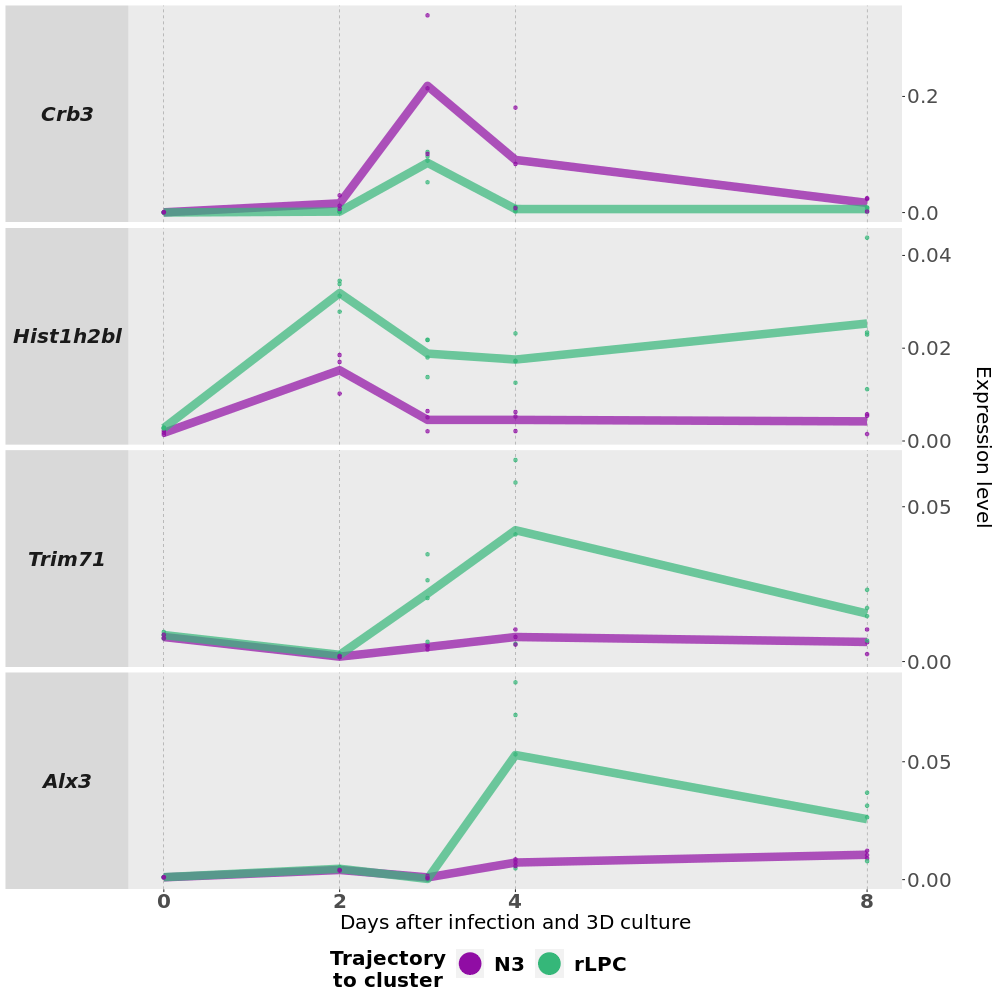

In [104]:
%%R -w 1000 -h 1000

select.genes <- c("Crb3", "Hist1h2bl", "Trim71", "Alx3" )

cluster_pseudobulk <- c("T_HA1-bulk", "T_HA2-bulk", "rLPC_rerepr5-bulk", "rLPC_HA1-bulk", "rLPC_HA2-bulk", "NLF_HA2-bulk", "I_HA2-bulk")

test <- 
crossing(
    tibble(
        name = cluster_pseudobulk
    ),
    tibble(
        trajectory = c("PZL")
    )
) %>%
mutate(
    clusters = name,
    filename = paste0( data.dir, "wot_data/", file_name_prefix, "_", trajectory, "_", clusters, "_trends2.txt" )
)

# vroom is super-fast in reading wide-format text files
tictoc::tic()
trend <- 
vroom::vroom( test$filename, id = "path") %>%
mutate(
    # parsing the file name to extract what I want
    trajectory = map_chr( path, ~strsplit(.x, "_")[[1]] %>% tail(4) %>% head(1) ),
    cluster    = map_chr( path, ~strsplit(.x, "_")[[1]] %>% tail(3) %>% head(1) ),
    pseudobulk = map_chr( path, ~strsplit(.x, "_")[[1]] %>% tail(2) %>% head(1) )
) %>%
dplyr::rename( day = id )
tictoc::toc()

df <-
trend[,c("trajectory", "day", "pseudobulk", "cluster", select.genes)]  %>%
mutate(
    fate = paste0( cluster, "_", pseudobulk ),
    category = ifelse( cluster %in% c("T", "I"), "N3", "rLPC" )
) %>%
pivot_longer( cols = select.genes, values_to = "expression", names_to = "gene" ) %>%
mutate(
    gene = factor(
        gene,
        levels = select.genes
    )
) %>%
dplyr::filter( day < 10 )

df_summary <- df %>%
  group_by(category, day, gene) %>%
  summarise(
      mean_value = mean(expression)
  )

Figure4D <-
ggplot() +
geom_line(
  data = df_summary, 
  aes(
      x = day, 
      y = mean_value, 
      group = category, 
      color = category
  ),
  linewidth = 4,
  show.legend = FALSE
) +
geom_point(
  data = df, 
  aes(x = day, y = expression, color = category)
) +
facet_wrap( gene ~ ., scale = "free_y" ) +
labs( x = "Days after infection and 3D culture", y = "Expression level\n" ) +
facet_grid( gene ~ ., scales = "free_y", switch = "y" ) +
scale_x_continuous( breaks = c(0, 2, 4, 8, 14) ) +
scale_y_continuous( position = "right", breaks = scales::breaks_pretty(n = 2) ) +
scale_colour_manual(
  name   = "Trajectory\nto cluster",
  values = stratum.color
) +
guides(
    colour = guide_legend(
      override.aes =
        list(
          size  = 10,
          alpha = 1.0
        ),
      ncol= 4,
      byrow = T
    )
) +
theme( 
    panel.grid   = element_blank(),
    panel.border = element_blank(),
    panel.grid.major.x = element_line( size=.1, color="black", linetype = "dashed" ),
    legend.position = "bottom",
    legend.direction = "horizontal",
    legend.justification = "center", 
    legend.title    = element_text( size = 20, face = "bold", hjust = 0.5),
    legend.text.align = 0.5,
    legend.text  = element_text( size = 20, face = "bold" ),
    strip.text.y.left = element_text(angle = 0, size = 20, face="bold.italic", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    strip.text.x.top  = element_text(angle = 0, size = 20, face="bold", margin = margin(0.25,0.25,0.25,0.25, "cm")),
    axis.text.x     = element_text( size = 20, face = "bold", hjust = 0.5 ),
    axis.text.y     = element_text( size = 20 ),
    axis.title      = element_text( size = 20, margin = margin(5, 5, 5, 5))
) 

options( repr.plot.height = 14, repr.plot.width = 14 )
Figure4D


# Figure S4

## Convert 4F Seurat object to scanpy Anndata object

In [105]:
%%R -i data_dir

tictoc::tic()
integrated <- readRDS( paste0( data.dir, "20230509_4F_integrated.rds") )
tictoc::toc()

integrated@meta.data %>%
dplyr::count( free.annotation2, library, condition3 )

180.951 sec elapsed
          free.annotation2               library condition3     n
1                    D02F0          mm10_hrepr_1         0F  2722
2                    D02F3                  3F-1         3F  3536
3                    D02F3                  3F-2         3F  3943
4                    D03F0                    D3         0F   691
5                    D03F3                    D3         3F  3012
6                    D03F4                    D3         4F  3642
7                    D04F0                    D4         0F   119
8                    D04F0          mm10_hrepr_3         0F  2802
9                    D04F0            rererepr_3         0F    20
10                   D04F3                  3F-1         3F    38
11                   D04F3                  3F-2         3F    22
12                   D04F3               3FD04-1         3F  2487
13                   D04F3               3FD04-2         3F  2103
14                   D04F3                    D4        

In [106]:
%%R -o bdata

tictoc::tic()
DefaultAssay( integrated ) <- "RNA"
bdata <- as.SingleCellExperiment(integrated)
tictoc::toc()

140.732 sec elapsed


In [107]:
bdata

AnnData object with n_obs × n_vars = 107295 × 37615
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'percent.mito', 'percent.ribo', 'percent.rbc', 'percent.transgenes', 'library', 'barcode', 'barcode2', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'free.annotation', 'nCount_3species', 'nFeature_3species', 'mUMIs', 'cUMIs', 'hUMIs', 'tUMIs', 'multiplet.99', 'multiplet.95', 'multiplet.90', 'mito.fraction.mm10', 'mito.fraction.hg38', 'mito.fraction.gg6a', 'query', 'batch', 'percent.ribo.expanded', 'doublet_scores', 'predicted_doublets', 'free.annotation2', 'doublet.barcode', 'stage', 'percent.trans', 'percent.mouse', 'percent.chick', 'percent.human', 'nCount_RNA_demux', 'nFeature_RNA_demux', 'integrated_snn_res.0.2', 'integrated_snn_res.0.3', 'integrated_snn_res.0.4', 'bulk', 'condition3', 'day3', 'pseudobulk', 'ident'
    layers: 'logcounts'

normalizing counts per cell
    finished (0:00:07)


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

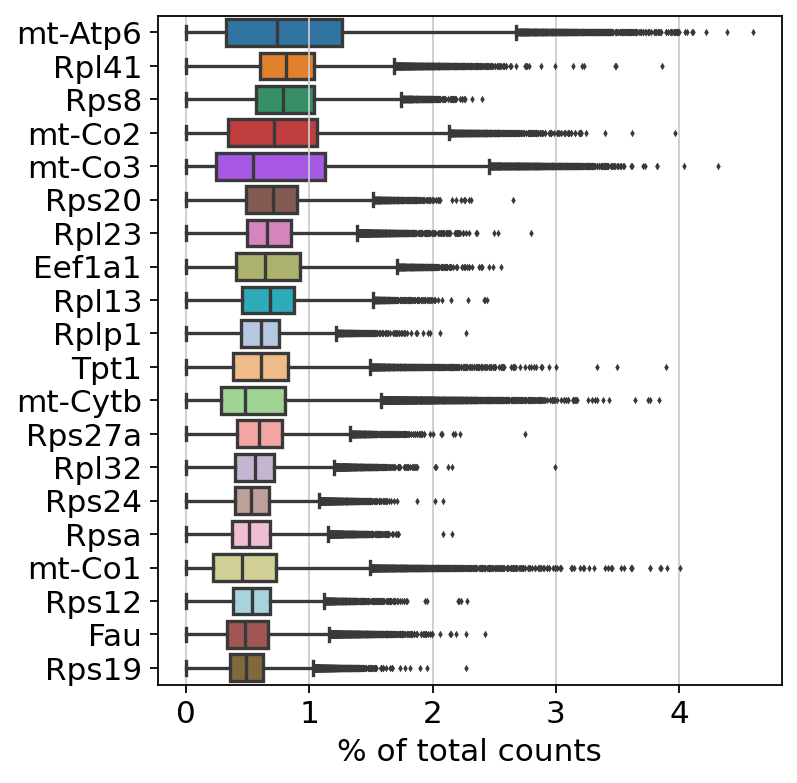

In [108]:
sc.pl.highest_expr_genes(bdata, n_top=20, )

In [109]:
# Without this normalization, all are just counts!
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)

normalizing counts per cell
    finished (0:00:02)


In [110]:
sc.pp.pca(bdata, n_comps=50)
sc.pp.neighbors(bdata, n_pcs=20, n_neighbors=20) 

computing PCA
    with n_comps=50
    finished (0:04:44)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)


In [111]:
# There is a problem with StringArray type of indices that needs to be corrected to objects

bdata.obs.index = bdata.obs.index.astype('object')
bdata.var.index = bdata.var.index.astype('object')

In [112]:
# write this
bdata.write( data_dir + '20231001_4F_init.h5ad')

In [113]:
bdata = ad.read(data_dir + '20231001_4F_init.h5ad')

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Figure S4D

In [114]:
mapping = {
    '4':'NonLFs',
    '5':'Infected (2D)',
    '6':'NonLFs (3D) - 1',
    '2':'NonLFs (3D) - 2',
    '1':'rLPC/LPC (3D)',
    '3':'LPC',
}

bdata.obs['label.0.2'] = bdata.obs['integrated_snn_res.0.2'].apply(lambda x: mapping[x])

# bdata.obs['label.0.2'] = temp # Beware this is inherently unstable and better to be incorporated to 
bdata.obs['label.0.2']

AAACCCACAAAGGCGT_1_1     NonLFs (3D) - 2
AAACCCACACAGTCCG_1_1     NonLFs (3D) - 2
AAACGAAAGGTCCAGA_1_1     NonLFs (3D) - 2
AAACGAACAGCTTTGA_1_1     NonLFs (3D) - 2
AAACGAAGTTACACTG_1_1     NonLFs (3D) - 2
                              ...       
TTTATGCTCATACGGT-1_10    NonLFs (3D) - 2
TTTGACTTCGCTGACG-1_10    NonLFs (3D) - 1
TTTGGAGTCGGACCAC-1_10      rLPC/LPC (3D)
TTTGTTGCACAGCGCT-1_10                LPC
TTTGTTGTCCTCTAGC-1_10    NonLFs (3D) - 2
Name: label.0.2, Length: 107295, dtype: category
Categories (6, object): ['rLPC/LPC (3D)', 'NonLFs (3D) - 2', 'LPC', 'NonLFs', 'Infected (2D)', 'NonLFs (3D) - 1']

In [115]:
mapping = {
    'NonLFs':'NonLFs (Std, 2D)', 
    'NonLFs (3D) - 1':'NonLFs 1 (Limb, 3D)',
    'NonLFs (3D) - 2':'NonLFs 2 (Limb, 3D)',
    'Infected (2D)':'NonLFs (Limb, 2D)',
    'rLPC/LPC (3D)':'rLPC/LPC (Limb, 3D)',
    'LPC':'LPC',
}

bdata.obs['label.0.2.reannotated'] = bdata.obs['label.0.2'].apply(lambda x: mapping[x])

In [116]:
sc.tl.dendrogram(bdata, groupby='label.0.2.reannotated',n_pcs=15)
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]


    using 'X_pca' with n_pcs = 15
Storing dendrogram info using `.uns['dendrogram_label.0.2.reannotated']`


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


[0, 2, 3, 4, 1, 5]

In [117]:
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_ordered"]

['rLPC/LPC (Limb, 3D)',
 'LPC',
 'NonLFs (Std, 2D)',
 'NonLFs (Limb, 2D)',
 'NonLFs 2 (Limb, 3D)',
 'NonLFs 1 (Limb, 3D)']

In [118]:
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]

[0, 2, 3, 4, 1, 5]

In [119]:
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_idx_ordered"]=[
    2,
    3,
    5,
    4,
    0,
    1,
]
# bdata.uns["dendrogram_label.0.2"]["categories_ordered"]=['NonLFs','Infected (2D)', 'NonLFs (3D)', 'rLPC/LPC (3D)', 'LPC (E9)', 'LPC (E10)']
bdata.uns["dendrogram_label.0.2.reannotated"]["categories_ordered"]=[
    'NonLFs (Std, 2D)',
    'NonLFs (Limb, 2D)', 
    'NonLFs 1 (Limb, 3D)', 
    'NonLFs 2 (Limb, 3D)', 
    'rLPC/LPC (Limb, 3D)', 
    'LPC', 
]

categories: rLPC/LPC (Limb, 3D), NonLFs 2 (Limb, 3D), LPC, etc.
var_group_labels: NonLFs, 3D
cultured, early
LP, etc.


/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_tidy.mask(~obs_bool).groupby(level=0).mean().fillna(0)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatte

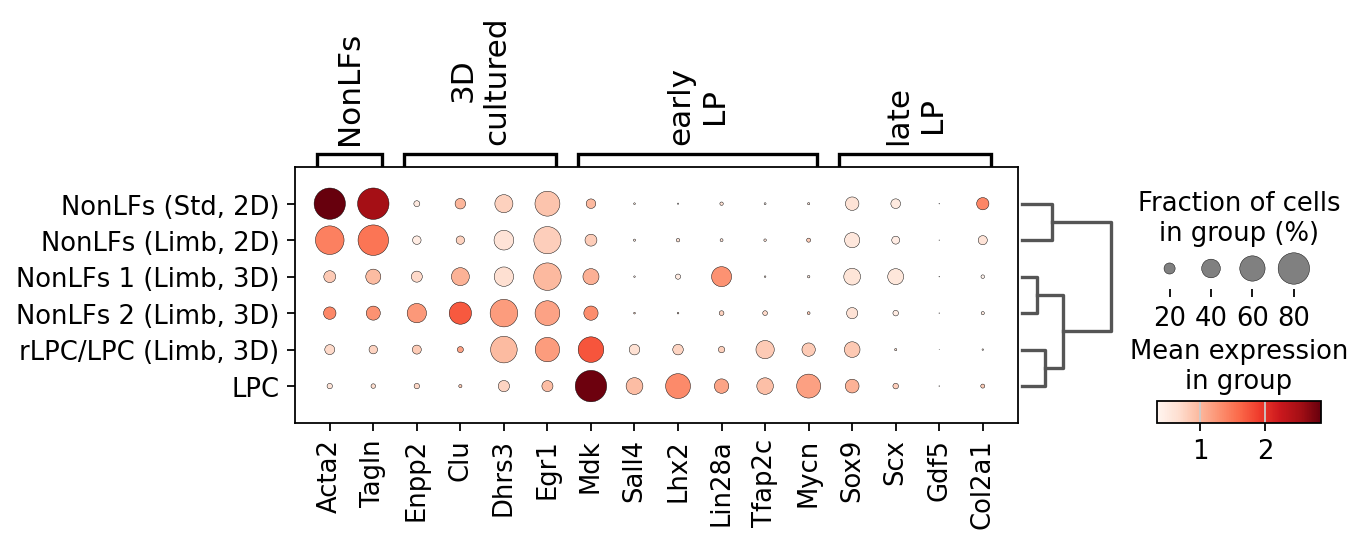

In [120]:
markers_genes_dict = {
    'NonLFs': ['Acta2','Tagln'],
    '3D\ncultured' : ['Enpp2','Clu','Dhrs3',#'Col18a1',
                      'Egr1'],
#    'Transgenes' : ['Prdm16', 'Zbtb16', 'hPLZF', 'hLin41'],
    'early\nLP': ['Mdk','Sall4', 'Lhx2', 'Lin28a', 
                  #'Trim71',
                  'Tfap2c', 'Mycn'],
    'late\nLP': ['Sox9', 'Scx', 'Gdf5', 'Col2a1']
}

sc.pl.dotplot(
    bdata, 
    var_names=markers_genes_dict, 
    groupby='label.0.2.reannotated', 
    var_group_labels=None,
    dendrogram=True, 
    mean_only_expressed=True,
    dot_max=0.8,
#    save='FigureS4D.png'
)

## Figure S4H


In [121]:
bdata_subset = bdata[bdata.obs['integrated_snn_res.0.2'].isin(['1'])]
bdata_subset = bdata_subset[bdata_subset.obs['condition3'].isin(['cLPC','3F', '4F'])]
#bdata_subset = bdata_subset[~bdata_subset.obs['free.annotation2'].isin(['D02F0', 'D04F0', 'D08F0', 'D14F0', 'E10.5 (Scx+)', 'E11.5 (Scx+)', 'E11.5 (Tcf4+)', 'E11.5 (Tcf4+fibro)', 'E12.5', 'E12.5 (Osr1+)', 'NonLFs', 'NonLFs (3D)'])]
temp = bdata_subset.obs

In [122]:
bdata_subset = bdata_subset[bdata_subset.obs['condition3'].isin(['cLPC','3F','4F'])]

bdata_subset.obs['primary'] = 'rLPCs (3-factor) in 3D culture (rLPC/LPC cluster)'
bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['cLPC'])] = 'E9-10 LPCs in 3D culture (rLPC/LPC cluster)'
bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['4F'])] = 'rLPCs (4-factor) in 3D culture (rLPC/LPC cluster)'
temp = bdata_subset.obs

/tmp/ipykernel_31463/2283391787.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata_subset.obs['primary'] = 'rLPCs (3-factor) in 3D culture (rLPC/LPC cluster)'
/tmp/ipykernel_31463/2283391787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['cLPC'])] = 'E9-10 LPCs in 3D culture (rLPC/LPC cluster)'
/tmp/ipykernel_31463/2283391787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdata_subset.obs['primary'][bdata_subset.obs['condition3'].isin(['4F'])] = 'rLPCs (4-factor) in 3D culture (rLPC

/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_tidy.mask(~obs_bool).groupby(level=0).mean().fillna(0)
/home/cl266/anaconda3/envs/jlab/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatte

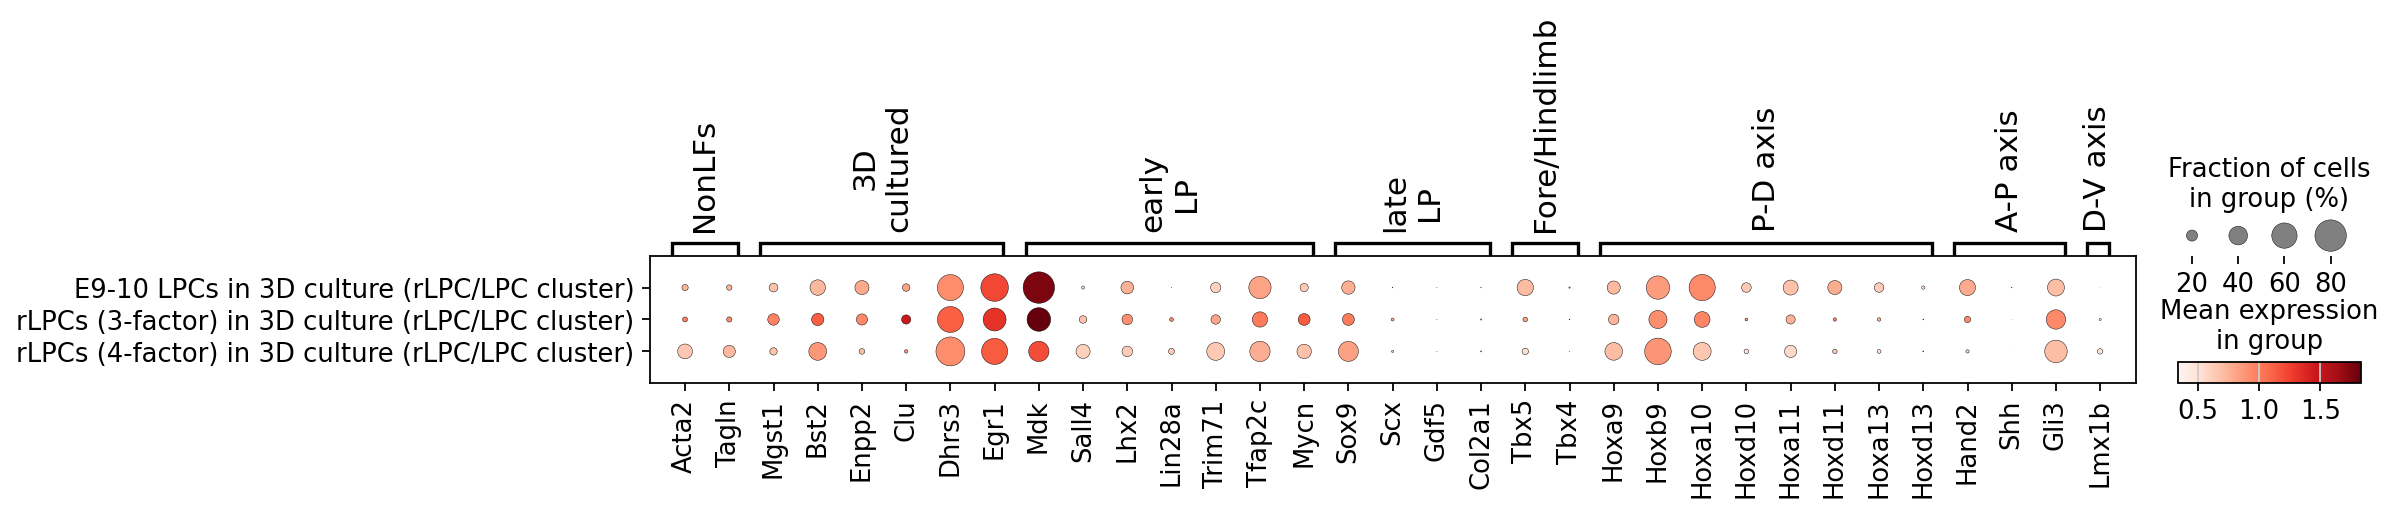

In [123]:
markers_genes_dict = {
    'NonLFs': ['Acta2','Tagln'],
    '3D\ncultured' : ['Mgst1', 'Bst2','Enpp2','Clu','Dhrs3','Egr1'],
#    'Transgenes' : ['Prdm16', 'Zbtb16', 'hLin41'],
    'early\nLP': ['Mdk','Sall4', 'Lhx2', 'Lin28a', 'Trim71','Tfap2c', 'Mycn'],
    'late\nLP': ['Sox9', 'Scx', 'Gdf5', 'Col2a1'],
    'Fore/Hindlimb': ['Tbx5', 'Tbx4'],
    'P-D axis': ['Hoxa9','Hoxb9','Hoxa10','Hoxd10','Hoxa11','Hoxd11','Hoxa13','Hoxd13'],
    'A-P axis': ['Hand2', 'Shh', 'Gli3'],
    'D-V axis': ['Lmx1b'],
}

sc.pl.dotplot(
    bdata_subset, 
    var_names=markers_genes_dict, 
    groupby='primary', 
    var_group_labels=None,
    dendrogram=False, 
    mean_only_expressed=True,
    dot_max=0.8,
#    save='FigureS4H.png'
)